# Word2vec Beginner

In [1]:
import tensorflow as tf

In [181]:
import urllib
import numpy as np
import collections
import math
import os
import random
import zipfile
import matplotlib.pyplot as plt

In [28]:
import logging
from logging import info
root = logging.getLogger()
for handler in root.handlers[:]:
    root.removeHandler(handler)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # adds a default StreamHanlder
#root.addHandler(logging.StreamHandler())

In [747]:
VOCAB_SIZE = 71000
VECTOR_SIZE = 200
BATCH_SIZE = 1000000
WINDOW_SIZE = 5
NUM_SKIPS = 2
MIN_COUNT = 5

In [735]:
# Step 1: Download the data.
url = 'http://mattmahoney.net/dc/'


def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urllib.urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    print(statinfo.st_size)
    raise Exception(
        'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)


Found and verified text8.zip


In [736]:
# Read the data into a list of strings.
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data

words = read_data(filename)
print('Data size', len(words))

Data size 17005207


In [235]:
words = 'apple banana car door egg fire giraffe hen ink jam kill lamp moon noon opus period rat sat tree ultra van window xray yellow zebra'.split(b" ")

In [737]:
print(words[:20])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english']


In [751]:
from tensorflow.python.client import device_lib
local_device_protos = device_lib.list_local_devices()
print(local_device_protos)

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13366109645251708533
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 333840384
locality {
  bus_id: 2
}
incarnation: 11778077645340841433
physical_device_desc: "device: 0, name: Tesla K40m, pci bus id: 0000:82:00.0"
]


## Build Dataset

In [738]:
%%time
# Count array
UNK_INDEX = 0
count = [['UNK',-1]]
count.extend(collections.Counter(words).most_common(VOCAB_SIZE-1))

CPU times: user 5.85 s, sys: 148 ms, total: 6 s
Wall time: 5.78 s


In [739]:
count[:10]

[['UNK', -1],
 ('the', 1061396),
 ('of', 593677),
 ('and', 416629),
 ('one', 411764),
 ('in', 372201),
 ('a', 325873),
 ('to', 316376),
 ('zero', 264975),
 ('nine', 250430)]

In [740]:
%%time
dictionary = dict()
for word, _ in count:
    dictionary[word] = len(dictionary)

# will contain the indices to be used in our network
data = list()
unk_count = 0
for word in words:
    if word in dictionary:
        index = dictionary[word]
    else:
        index = UNK_INDEX
        unk_count += 1
    data.append(index)
    
count[0][1] = unk_count

reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

CPU times: user 5.47 s, sys: 144 ms, total: 5.61 s
Wall time: 5.39 s


In [518]:
del words

In [519]:
print(data[:10])
print([reverse_dictionary[i] for i in data[:10]])

[5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]
['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


## Create Batch

In [376]:
import time

In [396]:
data_index = 0
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

#batch, labels = generate_batch(batch_size=BATCH_SIZE, num_skips=NUM_SKIPS, skip_window=WINDOW_SIZE)

### Custom Batch process

In [ ]:
BATCH_SIZE = 5
WINDOW_SIZE = 4

In [384]:
print(time.strftime("%d:%M:%y %H:%m:%S"))

20:59:16 22:12:54


In [741]:
curr_target_index = 0
curr_window_index = 0
alltime_word_index = 0
def generate_batch_custom(batch_size, window_size):
    global curr_target_index, curr_window_index, alltime_word_index
    
    # batch_size = len(data)
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    batch_iter = 0
    
    while True:
        if curr_target_index >= len(data):
            print("====== Epoch started at {}".format(time.strftime("%d-%m-%Y %H:%M:%S")))
        curr_target_index = curr_target_index % len(data)
        reduced_window = np.random.randint(window_size)
        batch_ended = False
        supposed_window_start = max(0, curr_target_index - window_size + reduced_window)
        window_end = min(len(data), curr_target_index + window_size - reduced_window)
        if curr_window_index and curr_window_index >= supposed_window_start and curr_window_index <= window_end:
            window_start = curr_window_index
        else:
            window_start = supposed_window_start
        curr_window_index = window_start
        # print("{}: ({}){} -> {}".format(curr_target_index, supposed_window_start, window_start, window_end))

        for (pos2, word2) in enumerate(data[window_start: window_end+1], window_start):
            if pos2 == curr_target_index:
                curr_window_index += 1
                continue
            batch[batch_iter] = data[curr_target_index]
            labels[batch_iter] = word2
            curr_window_index += 1
            batch_iter += 1
            
            if batch_iter >= batch_size:
                batch_ended = True
                break

        if batch_ended:
            if curr_window_index > window_end: 
                curr_target_index += 1
                alltime_word_index += 1
                curr_window_index += 1
            break;
        else:
            curr_window_index = None
        curr_target_index += 1
        alltime_word_index += 1

    return batch, labels, alltime_word_index

# batch, labels = generate_batch_custom(batch_size=BATCH_SIZE, window_size=WINDOW_SIZE)

In [761]:
ANALOGY_FILE = '/mnt/data2/shalaby/tensorflow/word2vec/questions-words.txt'
questions = []
questions_skipped = 0
with open(ANALOGY_FILE, "rb") as analogy_f:
    for line in analogy_f:
        if line.startswith(b":"):
            continue
        line_words = line.strip().lower().split(b" ")
        ids = [dictionary.get(w.strip()) for w in line_words]
        if None in ids or len(ids) != 4:
            questions_skipped += 1
        else:
            questions.append(np.array(ids))
print("Questions: ", len(questions))
print("questions skipped: " , questions_skipped)
analogy_questions = np.array(questions, dtype=np.int32)

Questions:  17827
questions skipped:  1717


In [399]:
%%time
for i in range(100000):
    batch, labels = generate_batch_custom(batch_size=BATCH_SIZE, window_size=WINDOW_SIZE)

CPU times: user 2.17 s, sys: 0 ns, total: 2.17 s
Wall time: 2.1 s


In [400]:
%%time
for i in range(100000):
    batch, labels = generate_batch(batch_size=BATCH_SIZE, num_skips=NUM_SKIPS, skip_window=WINDOW_SIZE)

CPU times: user 3.67 s, sys: 0 ns, total: 3.67 s
Wall time: 3.55 s


In [374]:
batch, labels = generate_batch_custom(batch_size=BATCH_SIZE, window_size=WINDOW_SIZE)
for i in range(len(batch)):
    print(reverse_dictionary[batch[i]], '-> ', [reverse_dictionary[d] for d in labels[i,:] ] )

car ->  ['banana']
car ->  ['door']
door ->  ['apple']
door ->  ['banana']
door ->  ['car']
door ->  ['egg']
door ->  ['fire']
door ->  ['giraffe']
egg ->  ['banana']
egg ->  ['car']
egg ->  ['door']
egg ->  ['fire']
egg ->  ['giraffe']
egg ->  ['hen']
fire ->  ['egg']
fire ->  ['giraffe']


In [333]:
for i in range(16):
    print(reverse_dictionary[batch[i]], '-> ', [reverse_dictionary[d] for d in labels[i,:] ] )

car ->  ['apple']
door ->  ['banana']
egg ->  ['door']
fire ->  ['door']
giraffe ->  ['egg']
hen ->  ['ink']
ink ->  ['hen']
jam ->  ['kill']
kill ->  ['jam']
lamp ->  ['moon']
moon ->  ['noon']
noon ->  ['period']
opus ->  ['noon']
period ->  ['rat']
rat ->  ['opus']
sat ->  ['period']


In [327]:
(words, counts, words_per_epoch, epoch, total_words, examples,
         labels) = word2vec.skipgram(filename='/mnt/data2/shalaby/tensorflow/word2vec/small_sample.txt',
                                              batch_size=5,
                                              window_size=2,
                                              min_count=1,
                                              subsample=0)
word2_id = {}
id2_word = {}
with tf.Session() as sess:
    for i in range(10):
        w_v, c_v, wpe_v, e_v, tw_v, ex_v, l_v = sess.run([words, counts, words_per_epoch, epoch, total_words, examples, labels])
        if i ==0: 
            print(w_v)
            id2_word = {x:v for x,v in enumerate(w_v)}
            word2_id = {v:k for (k,v) in id2_word.items()}
        print(wpe_v, e_v, tw_v)
        print([id2_word[x] for x in ex_v])
        print([id2_word[x] for x in l_v])

['UNK' 'hen' 'tree' 'period' 'sat' 'moon' 'zebra' 'lamp' 'kill' 'rat'
 'apple' 'banana' 'car' 'van' 'xray' 'egg' 'queeen' 'jam' 'fire' 'opus'
 'noon' 'giraffe' 'ink' 'ultra' 'door' 'yellow' 'window']
26 76 1016
['apple', 'apple', 'banana', 'banana', 'banana']
['banana', 'car', 'apple', 'car', 'door']
76
26 76 1016
['egg', 'fire', 'fire', 'fire', 'fire']
['fire', 'door', 'egg', 'giraffe', 'hen']
76
26 76 1016
['hen', 'hen', 'hen', 'ink', 'ink']
['giraffe', 'ink', 'jam', 'giraffe', 'hen']
76
26 76 1016
['kill', 'kill', 'kill', 'lamp', 'lamp']
['jam', 'lamp', 'moon', 'kill', 'moon']
76
26 76 1016
['noon', 'opus', 'opus', 'opus', 'opus']
['opus', 'moon', 'noon', 'period', 'queeen']
76
26 76 1016
['rat', 'sat', 'sat', 'tree', 'tree']
['sat', 'rat', 'tree', 'sat', 'ultra']
76
26 76 1016
['van', 'window', 'window', 'xray', 'xray']
['window', 'van', 'xray', 'van', 'window']
76
26 76 1016
['zebra', 'zebra', 'zebra', 'apple', 'apple']
['yellow', 'apple', 'banana', 'zebra', 'banana']
76
26 76 101

In [606]:
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 100    # Number of negative examples to sample.

In [787]:
graph = tf.Graph()

with graph.as_default():

    # Input data.
    train_inputs = tf.placeholder(dtype=tf.int32, shape=[BATCH_SIZE])
    train_labels = tf.placeholder(dtype=tf.int32, shape=[BATCH_SIZE, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    with tf.device("/gpu:0"):
        # W matrix
        #init_width = 0.5 / VECTOR_SIZE
        init_width = 1
        embeddings = tf.Variable(initial_value=tf.random_uniform([VOCAB_SIZE, VECTOR_SIZE], -init_width, init_width), dtype='float32')
        # actual embedding vector for the input word
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)
        
        # W' matrix
        nce_weights = tf.Variable(initial_value=tf.truncated_normal([VOCAB_SIZE, VECTOR_SIZE],
                      stddev=1.0 / math.sqrt(VECTOR_SIZE)))
        nce_biases = tf.Variable(tf.zeros([VOCAB_SIZE]))

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    nce_loss = tf.nn.nce_loss(nce_weights, nce_biases, embed, train_labels,
                 num_sampled, VOCAB_SIZE)
    loss = tf.reduce_mean(nce_loss)

    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(0.2).minimize(loss)
#     optimizer = tf.train.AdamOptimizer(learning_rate=0.1).minimize(loss)

        
    ###### Eval ####################

    analogy_a = tf.placeholder(dtype=tf.int32, shape=[None], name='a')
    analogy_b = tf.placeholder(dtype=tf.int32, shape=[None], name='b')
    analogy_c = tf.placeholder(dtype=tf.int32, shape=[None], name='c')


    nemb = tf.nn.l2_normalize(embeddings, 1)
    a_emb = tf.gather(nemb, analogy_a)
    b_emb = tf.gather(nemb, analogy_b)
    c_emb = tf.gather(nemb, analogy_c)

    target = (b_emb - a_emb) + c_emb # if we are correct, target should be close to the actual word

    dist = tf.matmul(target, nemb, transpose_b=True) # 1xV

    _, pred_idx = tf.nn.top_k(dist, 4)


    ######### Not really used now ##############

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(
            valid_embeddings, normalized_embeddings, transpose_b=True)
        

    # Add variable initializer.
    init = tf.global_variables_initializer()


In [789]:
graph.get_collection('a')

[]

In [805]:
def eval_word2vec(session):
    total = analogy_questions.shape[0]
    start = 0
    correct = 0
    while start < total:
        limit = start + 2500
        subset = analogy_questions[start:limit, :]
        idx = session.run([pred_idx], {
            analogy_a: subset[:, 0],
            analogy_b: subset[:, 1],
            analogy_c: subset[:, 2]
        })[0]
        start = limit
        for question in xrange(subset.shape[0]):
            for j in xrange(4):
                #if idx[question, j] == subset[question, 3]:
                if idx[question, j] == subset[question, 3]:
                    # Bingo! We predicted correctly. E.g., [italy, rome, france, paris].
                    correct += 1
                    break
                #elif idx[question, j] in subset[question, :3]:
                elif idx[question,j] in subset[question, :3]:
                    # We need to skip words already in the question.
                    continue
                else:
                    # The correct label is not the precision@1
                    break
    print()
    print("Eval %4d/%d accuracy = %4.1f%%" % (correct, total,
                                              correct * 100.0 / total))

In [792]:
with tf.Session() as session:
    subset = analogy_questions[0:50, :]
    idx = session.run([pred_idx], feed_dict={
        analogy_a: subset[:, 0],
        analogy_b: subset[:, 1],
        analogy_c: subset[:, 2]
    })

TypeError: Cannot interpret feed_dict key as Tensor: Tensor Tensor("Placeholder:0", shape=(1000000,), dtype=int32) is not an element of this graph.

In [772]:
total = analogy_questions.shape[0]
start = 0
while start < total:
    limit = start + 2500
    subset = analogy_questions[start:limit, :]
    print(subset[:, 0])
    print(subset[:, 1])
    print(subset[:, 2])
    break

[ 3067  3067  3067 ..., 46937 46937 46937]
[1248 1248 1248 ..., 7463 7463 7463]
[ 7169 29292  3880 ..., 16192  8650 35720]


In [529]:
valid_embeddings.get_shape()

TensorShape([Dimension(16), Dimension(200)])

In [127]:
nce_loss.get_shape()

TensorShape([Dimension(100)])

In [807]:
num_steps = 30001

<IPython.core.display.Javascript object>


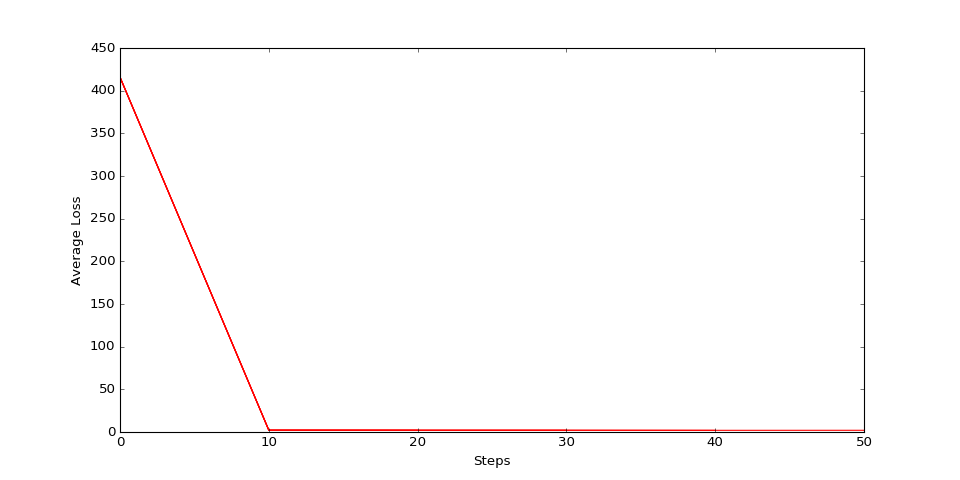

Initialized
started at: 23-12-2016 01:52:12
words/sec: 258582431
Average loss at step  0 :  415.826293945

Eval    0/17827 accuracy =  0.0%
words/sec:    77033
Average loss at step  10 :  2.12942190552

Eval    0/17827 accuracy =  0.0%
words/sec:    78599
Average loss at step  20 :  2.06051399231

Eval    0/17827 accuracy =  0.0%
====== Epoch started at 23-12-2016 01:53:02
words/sec:    76646
Average loss at step  30 :  2.04752041626

Eval    0/17827 accuracy =  0.0%
words/sec:    77187
Average loss at step  40 :  1.96054872131

Eval    0/17827 accuracy =  0.0%
words/sec:    80020
Average loss at step  50 :  2.00518522644


KeyboardInterrupt: 

In [809]:
%%time
%matplotlib notebook
losses = []
steps = []
fig = plt.figure(figsize=(12,6), dpi=80)
ax = plt.subplot(111)
ax.set_xlabel("Steps")
ax.set_ylabel("Average Loss")
with tf.Session(graph=graph) as session:
    init.run()
    print("Initialized")
    
    average_loss = 0
    last_words = 0
    last_time = time.time()
    print("started at: %s" % time.strftime("%d-%m-%Y %H:%M:%S"))
    for step in xrange(num_steps):
#         batch_inputs, batch_labels = generate_batch(
#             BATCH_SIZE, NUM_SKIPS, WINDOW_SIZE)
        batch_inputs, batch_labels, words_so_far = generate_batch_custom(BATCH_SIZE, WINDOW_SIZE)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val
        
        # print loss_val

        if step % 10 == 0:
            words_since_last_time = words_so_far - last_words
            curr_time = time.time()
            rate = words_since_last_time / (time.time() - last_time)
            last_time = curr_time
            last_words = words_so_far
            print("words/sec: %8.0f" % rate)
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            losses.append(average_loss)
            steps.append(step)
            ax.plot(steps, losses, 'r-')
            fig.canvas.draw()
            
            average_loss = 0
            
            eval_word2vec(session)

#         # Note that this is expensive (~20% slowdown if computed every 500 steps)
#         if step % 10000 == 0:
#             sim = similarity.eval() # Big 16 x V matrix
#             for i in xrange(valid_size):
#                 valid_word = reverse_dictionary[valid_examples[i]]
#                 top_k = 8  # number of nearest neighbors
#                 nearest = (-sim[i, :]).argsort()[1:top_k + 1]
#                 log_str = "Nearest to %s:" % valid_word
#                 for k in xrange(top_k):
#                     close_word = reverse_dictionary[nearest[k]]
#                     log_str = "%s %s," % (log_str, close_word)
#                 print(log_str)
        
    final_embeddings = normalized_embeddings.eval()



In [136]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    #plt.savefig(filename)



In [137]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

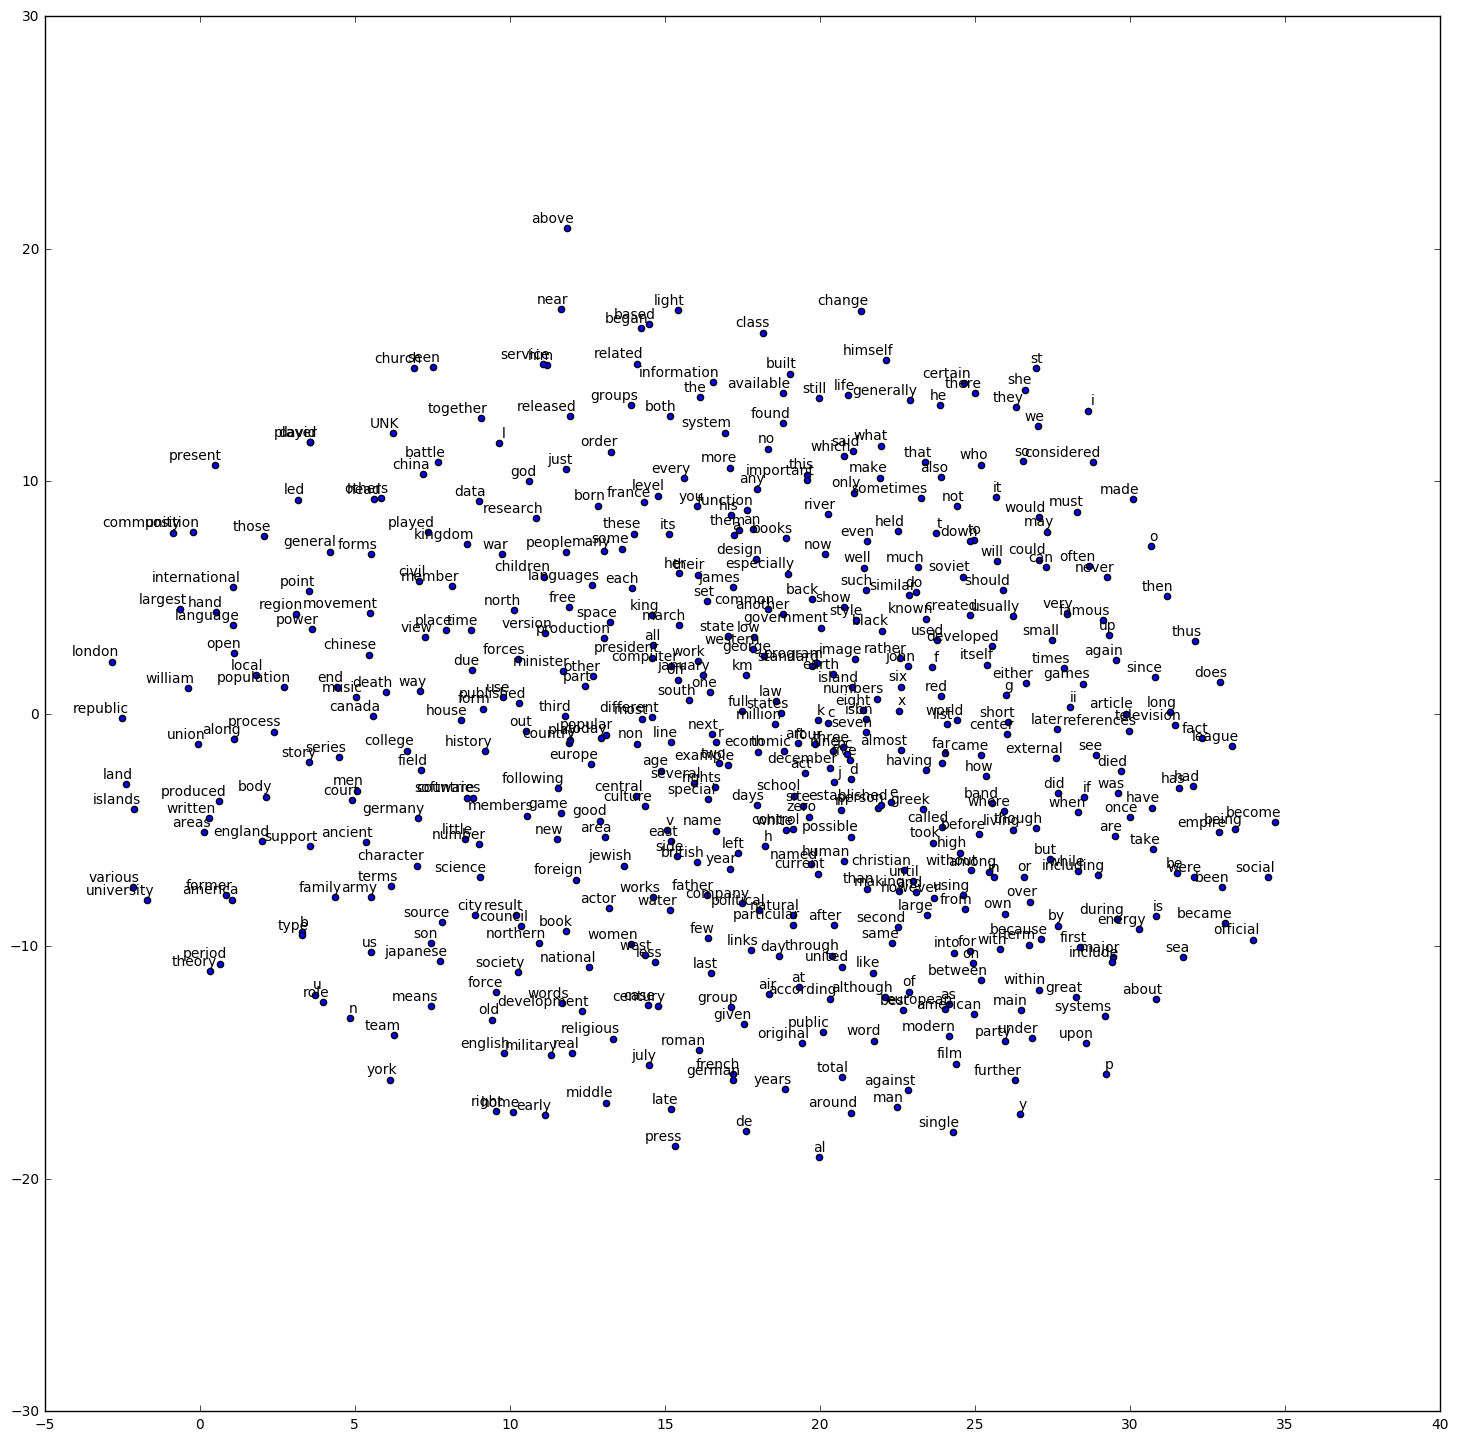

In [138]:
%matplotlib inline
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reverse_dictionary[i] for i in xrange(plot_only)]
plot_with_labels(low_dim_embs, labels)

# Word2vec Gensim

In [2]:
from gensim.models.word2vec import Word2Vec
from nltk.tokenize import RegexpTokenizer
import string
import numpy as np

Using gpu device 0: Tesla K40m (CNMeM is disabled, cuDNN 5105)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [3]:
SAMPLE_RATIO = 0.0001
root_location = "/mnt/data2/shalaby/"
training_file = root_location + 'docs_output_training_validation_documents_' + str(SAMPLE_RATIO)

In [4]:
MAX_BATCH_SIZE = 10000
MIN_COUNT = 10
WINDOW_SIZE = 5

In [8]:
NUMBER_INDICATOR = "number_inidicator"
CURRENCY_INDICATOR = "currency_inidicator"
CHEMICAL_INDICATOR = "chemical_inidicator"
def stemtokenizer(text):
    """ MAIN FUNCTION to get clean stems out of a text. A list of clean stems are returned """
    tokenizer = RegexpTokenizer(r'\s+', gaps=True)
    tokens = tokenizer.tokenize(text)
    stems = []  # result
    for token in tokens:
        stem = token.lower()
        stem = stem.strip(string.punctuation)
        if stem:
            if is_number(stem):
                stem = NUMBER_INDICATOR
            elif is_currency(stem):
                stem = CURRENCY_INDICATOR
            elif is_chemical(stem):
                stem = CHEMICAL_INDICATOR
            else:
                stem = stem.strip(string.punctuation)
            if stem and len(stem) >= 1:
                # extract uni-grams
                stems.append(stem)
    del tokens
    return stems

def is_number(str):
    """ Returns true if given string is a number (float or int)"""
    try:
        float(str.replace(",", ""))
        return True
    except ValueError:
        return False

def is_currency(str):
    return str[0] == "$"

def is_chemical(str):
    return str.count("-") > 3

In [14]:
word2vec_model = Word2Vec(size=200, window=WINDOW_SIZE, min_count=MIN_COUNT, 
                          max_vocab_size=None, 
                          sample=1e-3, seed=1000, workers=16, 
                          sg=0, 
                          hs=0, negative=100,  
                          iter=1, 
                          alpha=0.2, 
                          batch_words=MAX_BATCH_SIZE)

       
class SimplePatentDocumentIterator(object):
    def __init__(self, filename):
        self.filename = filename
    def __iter__(self):
        with open(self.filename) as file_obj:
            for line in file_obj:
                if not line.strip(): continue
                (doc_id, text) = eval(line)
                yield stemtokenizer(text)

In [100]:
class SimpleInMemoryPatentDocumentIterator(object):
    def __init__(self, filename):
        self.filename = filename
        self.lines = []
        i = 0
        self.line_lengths = []
        with open(self.filename) as file_obj:
            for line in file_obj:
                if not line.strip(): continue
                i += 1
                (doc_id, text) = eval(line)
                tokens = stemtokenizer(text)
                self.lines.append(tokens)
                self.line_lengths.append(len(tokens))
                if i % 100 == 0:
                    print i
                if i > 5000:
                    break
        print("Line Lengths average: %.2f, max %d, min %d" % (np.mean(self.line_lengths), 
                                                              np.max(self.line_lengths), np.min(self.line_lengths)))
    def __iter__(self):
        for line_words in self.lines:
            yield line_words

In [101]:
in_mem = SimpleInMemoryPatentDocumentIterator(training_file)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
Line Lengths average: 6501.81, max 143997, min 494


In [107]:
len(np.where(np.array(in_mem.line_lengths) > 10000)[0])

746

In [26]:
%%time
i = 0
for x in SimplePatentDocumentIterator(training_file):
    print len(x)
    # print x[-100:]
    i += 1
    if i > 2:
        break

9363
2127
6174
CPU times: user 108 ms, sys: 4 ms, total: 112 ms
Wall time: 105 ms


In [22]:
%%time
in_memory_iterator = SimpleInMemoryPatentDocumentIterator(training_file)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
CPU times: user 1min 54s, sys: 2.48 s, total: 1min 57s
Wall time: 1min 56s


# Preprocess text

In [23]:
import cPickle as pickle
pickle.dump(in_memory_iterator.lines, open('/mnt/data2/shalaby/in_memory_lines.pkl', 'w'))

In [27]:
import sys
sys.getsizeof(in_memory_iterator.lines)

43048

In [32]:
%%time
with open('/mnt/data2/shalaby/in_memory_lines2.pkl', 'w') as f:
    for i in range(len(in_memory_iterator.lines)):
        f.write(str(in_memory_iterator.lines[i]) + "\n")

CPU times: user 3.41 s, sys: 540 ms, total: 3.95 s
Wall time: 4.39 s


In [33]:
%%time
read_lines = []
with open('/mnt/data2/shalaby/in_memory_lines2.pkl', 'rb') as f:
    read_lines.append(eval(f.readline()))

CPU times: user 12 ms, sys: 4 ms, total: 16 ms
Wall time: 8.66 ms


In [25]:
%%time
line_positions = dict()
with open(training_file) as f:
    
    i = 0
    line_positions[i] = f.tell()
    line = f.readline()
    while line:
        i+=1
        if not line.strip(): continue
        line_positions[i] = f.tell()
        line = f.readline()
    del line_positions[i]

CPU times: user 1.19 s, sys: 68 ms, total: 1.26 s
Wall time: 1.26 s


### Preprocess with opening a file for every thread

In [73]:
write_file_prefix = '/mnt/data2/shalaby/in_memory_lines_preprocessed-'
workers = []
batch_size = 50
start_from = 0
num_threads = 10
def preprocess(filename, start_from, batch_size):
    print "start_from: %d" % start_from
    batch_lines = []
    with open(filename, 'r') as file_obj:
        file_obj.seek(line_positions[start_from])
        print "finished seek"
        for i in range(batch_size):
            line = file_obj.readline()
            if i % 100 == 0:
                print i + start_from
            if not line.strip(): 
                continue
            (doc_id, text) = eval(line)
            %time tokens = stemtokenizer(text)
            batch_lines.append(tokens)
    
    with open(write_file_prefix + str(start_from), 'w') as batch_file:
        for i in range(len(batch_lines)):
            batch_file.write(str(batch_lines[i]) + "\n")

In [74]:
%%time
import threading
num_threads = 3
start_from = 0
file_obj = open(training_file, 'r')
lock = Lock()
for _ in xrange(num_threads):
    t = threading.Thread(target=preprocess, args=(file_obj, start_from, batch_size))
    t.start()
    start_from += batch_size
    workers.append(t)
for w in workers:
    w.join()

start_from: 0start_from: 50

 finished seekfinished seekstart_from: 100


finished seek
0
100
50
CPU times: user 40 ms, sys: 12 ms, total: 52 ms
Wall time: 37 ms
CPU times: user 60 ms, sys: 32 ms, total: 92 ms
CPU times: user 96 ms, sys: 52 ms, total: 148 ms
Wall time: 66.3 msWall time: 102 ms

CPU times: user 120 ms, sys: 52 ms, total: 172 ms
Wall time: 119 ms


Exception in thread Thread-102:
Traceback (most recent call last):
  File "/usr/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/usr/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "<ipython-input-73-3c885d21e65b>", line 20, in preprocess
    batch_lines.append(tokens)
NameError: global name 'tokens' is not defined

Exception in thread Thread-104:
Traceback (most recent call last):
  File "/usr/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/usr/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "<ipython-input-73-3c885d21e65b>", line 20, in preprocess
    batch_lines.append(tokens)
NameError: global name 'tokens' is not defined
Exception in thread Thread-103:
Traceback (most recent call last):
  File "/usr/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/usr/lib/python2.7/threa

### Preprocess with a single file obj

In [94]:
write_file_prefix = '/mnt/data2/shalaby/in_memory_lines_preprocessed-'
workers = []
batch_size = 10000
start_from = 0
num_threads = 10
def preprocess(file_obj, lock, start_from, batch_size):
    print "start_from: %d" % start_from
    batch_lines = []
    for i in range(batch_size):
        with lock:
            file_obj.seek(line_positions[start_from])
            line = file_obj.readline()
        if i % 100 == 0:
            print i + start_from
        if not line.strip(): 
            continue
        (doc_id, text) = eval(line)
        tokens = stemtokenizer(text)
        batch_lines.append(tokens)
    
    with open(write_file_prefix + str(start_from), 'w') as batch_file:
        for i in range(len(batch_lines)):
            batch_file.write(str(batch_lines[i]) + "\n")

In [95]:
%%time
import threading
from threading import Lock
num_threads = 1
start_from = 0
file_obj = open(training_file, 'r')
file_lock = Lock()
for _ in xrange(num_threads):
    t = threading.Thread(target=preprocess, args=(file_obj, file_lock, start_from, batch_size))
    t.start()
    start_from += batch_size
    workers.append(t)
for w in workers:
    w.join()

start_from: 0
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
CPU times: user 1min 32s, sys: 16 ms, total: 1min 32s
Wall time: 1min 31s


In [1]:
start_from

NameError: name 'start_from' is not defined

In [11]:
preprocess(training_file, start_from, batch_size)

start_from: 0


In [ ]:
for t in workers:
    t.join()

In [35]:
import threading

In [ ]:
threading.Thread()

In [42]:
%%time
word2vec_model2 = Word2Vec(size=200, window=WINDOW_SIZE, min_count=MIN_COUNT, 
                          max_vocab_size=None, 
                          sample=1e-3, seed=1000, workers=16, 
                          sg=0, 
                          hs=0, negative=100,  
                          iter=1, 
                          alpha=0.2, 
                          batch_words=MAX_BATCH_SIZE)
word2vec_model2.build_vocab(sentences=in_memory_iterator, 
                           progress_per=1000)

2016-12-23 03:41:09,202 : INFO : collecting all words and their counts
2016-12-23 03:41:09,205 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2016-12-23 03:41:11,391 : INFO : PROGRESS: at sentence #1000, processed 8128590 words, keeping 129825 word types
2016-12-23 03:41:12,958 : INFO : PROGRESS: at sentence #2000, processed 15694094 words, keeping 203279 word types
2016-12-23 03:41:14,664 : INFO : PROGRESS: at sentence #3000, processed 23939233 words, keeping 292098 word types
2016-12-23 03:41:16,517 : INFO : PROGRESS: at sentence #4000, processed 31841301 words, keeping 355772 word types
2016-12-23 03:41:18,351 : INFO : PROGRESS: at sentence #5000, processed 39837948 words, keeping 414461 word types
2016-12-23 03:41:19,903 : INFO : PROGRESS: at sentence #6000, processed 47470590 words, keeping 476515 word types
2016-12-23 03:41:21,537 : INFO : PROGRESS: at sentence #7000, processed 55628497 words, keeping 540806 word types
2016-12-23 03:41:23,052 : INFO : 

CPU times: user 2min 1s, sys: 9.71 s, total: 2min 11s
Wall time: 2min 12s


In [45]:
%%time
for epoch in range(20):
    info("****************** Epoch {}  *******************".format(epoch))
    %time word_count = word2vec_model2.train(sentences=in_memory_iterator, report_delay=10)
    print(word_count)
    result = word2vec_model2.accuracy('/mnt/data2/shalaby/tensorflow/word2vec/questions-words.txt', restrict_vocab=None)

2016-12-23 04:07:54,871 : INFO : ****************** Epoch 0  *******************
2016-12-23 04:07:54,875 : INFO : training model with 16 workers on 284872 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=100
2016-12-23 04:07:54,876 : INFO : expecting 62201 sentences, matching count from corpus used for vocabulary survey
2016-12-23 04:07:55,960 : INFO : PROGRESS: at 0.11% examples, 322785 words/s, in_qsize 32, out_qsize 0
2016-12-23 04:08:05,964 : INFO : PROGRESS: at 1.69% examples, 450162 words/s, in_qsize 31, out_qsize 0
2016-12-23 04:08:15,966 : INFO : PROGRESS: at 3.30% examples, 454534 words/s, in_qsize 32, out_qsize 0
2016-12-23 04:08:25,977 : INFO : PROGRESS: at 4.85% examples, 456260 words/s, in_qsize 32, out_qsize 1
2016-12-23 04:08:35,982 : INFO : PROGRESS: at 6.44% examples, 456811 words/s, in_qsize 31, out_qsize 0
2016-12-23 04:08:45,985 : INFO : PROGRESS: at 7.95% examples, 456729 words/s, in_qsize 31, out_qsize 0
2016-12-23 04:08:56,008 : INFO : PROGRESS:

CPU times: user 2h 38min 53s, sys: 46.3 s, total: 2h 39min 40s


2016-12-23 04:18:55,390 : INFO : precomputing L2-norms of word weight vectors
2016-12-23 04:19:09,683 : INFO : capital-common-countries: 0.0% (0/240)
2016-12-23 04:19:21,302 : INFO : capital-world: 0.0% (0/291)
2016-12-23 04:19:23,351 : INFO : currency: 0.0% (0/54)
2016-12-23 04:20:38,590 : INFO : city-in-state: 0.0% (0/1992)
2016-12-23 04:20:45,429 : INFO : family: 0.0% (0/182)
2016-12-23 04:21:11,626 : INFO : gram1-adjective-to-adverb: 0.0% (0/702)
2016-12-23 04:21:34,028 : INFO : gram2-opposite: 0.0% (0/600)
2016-12-23 04:22:23,980 : INFO : gram3-comparative: 0.0% (0/1332)
2016-12-23 04:22:54,335 : INFO : gram4-superlative: 0.0% (0/812)
2016-12-23 04:23:31,241 : INFO : gram5-present-participle: 0.0% (0/992)
2016-12-23 04:23:58,671 : INFO : gram6-nationality-adjective: 0.1% (1/736)
2016-12-23 04:24:48,185 : INFO : gram7-past-tense: 0.0% (0/1332)
2016-12-23 04:25:30,096 : INFO : gram8-plural: 0.0% (0/1122)
2016-12-23 04:25:58,502 : INFO : gram9-plural-verbs: 0.0% (0/756)
2016-12-23 04

Wall time: 10min 41s
291685543
CPU times: user 2h 40min 7s, sys: 47.9 s, total: 2h 40min 55s
Wall time: 10min 45s


2016-12-23 04:36:56,218 : INFO : precomputing L2-norms of word weight vectors
2016-12-23 04:37:09,989 : INFO : capital-common-countries: 0.0% (0/240)
2016-12-23 04:37:21,268 : INFO : capital-world: 0.0% (0/291)
2016-12-23 04:37:23,361 : INFO : currency: 0.0% (0/54)
2016-12-23 04:38:40,289 : INFO : city-in-state: 0.0% (0/1992)
2016-12-23 04:38:47,319 : INFO : family: 0.0% (0/182)
2016-12-23 04:39:14,258 : INFO : gram1-adjective-to-adverb: 0.0% (0/702)
2016-12-23 04:39:37,194 : INFO : gram2-opposite: 0.0% (0/600)
2016-12-23 04:40:28,007 : INFO : gram3-comparative: 0.0% (0/1332)
2016-12-23 04:40:58,968 : INFO : gram4-superlative: 0.0% (0/812)
2016-12-23 04:41:36,656 : INFO : gram5-present-participle: 0.0% (0/992)
2016-12-23 04:42:04,579 : INFO : gram6-nationality-adjective: 0.0% (0/736)
2016-12-23 04:42:55,030 : INFO : gram7-past-tense: 0.0% (0/1332)
2016-12-23 04:43:37,470 : INFO : gram8-plural: 0.0% (0/1122)
2016-12-23 04:44:06,081 : INFO : gram9-plural-verbs: 0.0% (0/756)
2016-12-23 04

291679236
CPU times: user 2h 40min 55s, sys: 50.8 s, total: 2h 41min 46s
Wall time: 10min 49s
291683705

2016-12-23 04:55:08,121 : INFO : precomputing L2-norms of word weight vectors
2016-12-23 04:55:20,692 : INFO : capital-common-countries: 0.0% (0/240)
2016-12-23 04:55:31,738 : INFO : capital-world: 0.0% (0/291)
2016-12-23 04:55:33,777 : INFO : currency: 0.0% (0/54)
2016-12-23 04:56:50,122 : INFO : city-in-state: 0.0% (0/1992)
2016-12-23 04:56:56,921 : INFO : family: 0.0% (0/182)
2016-12-23 04:57:22,910 : INFO : gram1-adjective-to-adverb: 0.0% (0/702)
2016-12-23 04:57:45,133 : INFO : gram2-opposite: 0.0% (0/600)
2016-12-23 04:58:34,531 : INFO : gram3-comparative: 0.0% (0/1332)
2016-12-23 04:59:04,692 : INFO : gram4-superlative: 0.0% (0/812)
2016-12-23 04:59:41,944 : INFO : gram5-present-participle: 0.0% (0/992)
2016-12-23 05:00:09,133 : INFO : gram6-nationality-adjective: 0.0% (0/736)
2016-12-23 05:00:58,628 : INFO : gram7-past-tense: 0.0% (0/1332)
2016-12-23 05:01:40,355 : INFO : gram8-plural: 0.0% (0/1122)
2016-12-23 05:02:08,381 : INFO : gram9-plural-verbs: 0.0% (0/756)
2016-12-23 05


CPU times: user 2h 41min 3s, sys: 56 s, total: 2h 41min 59s
Wall time: 10min 52s
291689677


2016-12-23 05:13:23,789 : INFO : capital-common-countries: 0.0% (0/240)
2016-12-23 05:13:35,654 : INFO : capital-world: 0.0% (0/291)
2016-12-23 05:13:37,843 : INFO : currency: 0.0% (0/54)
2016-12-23 05:14:57,950 : INFO : city-in-state: 0.1% (1/1992)
2016-12-23 05:15:05,119 : INFO : family: 0.0% (0/182)
2016-12-23 05:15:32,872 : INFO : gram1-adjective-to-adverb: 0.0% (0/702)
2016-12-23 05:15:56,565 : INFO : gram2-opposite: 0.0% (0/600)
2016-12-23 05:16:48,733 : INFO : gram3-comparative: 0.0% (0/1332)
2016-12-23 05:17:20,829 : INFO : gram4-superlative: 0.0% (0/812)
2016-12-23 05:18:00,123 : INFO : gram5-present-participle: 0.0% (0/992)
2016-12-23 05:18:29,228 : INFO : gram6-nationality-adjective: 0.0% (0/736)
2016-12-23 05:19:21,412 : INFO : gram7-past-tense: 0.0% (0/1332)
2016-12-23 05:20:05,627 : INFO : gram8-plural: 0.0% (0/1122)
2016-12-23 05:20:35,239 : INFO : gram9-plural-verbs: 0.0% (0/756)
2016-12-23 05:20:35,242 : INFO : total: 0.0% (1/11143)
2016-12-23 05:20:35,397 : INFO : ***

CPU times: user 2h 40min 7s, sys: 52.7 s, total: 2h 41min
Wall time: 10min 47s
291687800


2016-12-23 05:31:47,980 : INFO : capital-common-countries: 0.0% (0/240)
2016-12-23 05:31:59,549 : INFO : capital-world: 0.0% (0/291)
2016-12-23 05:32:01,575 : INFO : currency: 0.0% (0/54)
2016-12-23 05:33:17,685 : INFO : city-in-state: 0.1% (2/1992)
2016-12-23 05:33:24,465 : INFO : family: 0.0% (0/182)
2016-12-23 05:33:50,596 : INFO : gram1-adjective-to-adverb: 0.0% (0/702)
2016-12-23 05:34:13,081 : INFO : gram2-opposite: 0.0% (0/600)
2016-12-23 05:35:02,943 : INFO : gram3-comparative: 0.0% (0/1332)
2016-12-23 05:35:33,408 : INFO : gram4-superlative: 0.0% (0/812)
2016-12-23 05:36:10,379 : INFO : gram5-present-participle: 0.0% (0/992)
2016-12-23 05:36:37,707 : INFO : gram6-nationality-adjective: 0.0% (0/736)
2016-12-23 05:37:27,483 : INFO : gram7-past-tense: 0.0% (0/1332)
2016-12-23 05:38:09,301 : INFO : gram8-plural: 0.0% (0/1122)
2016-12-23 05:38:37,554 : INFO : gram9-plural-verbs: 0.0% (0/756)
2016-12-23 05:38:37,574 : INFO : total: 0.0% (2/11143)
2016-12-23 05:38:37,869 : INFO : ***

CPU times: user 2h 40min 23s, sys: 56.3 s, total: 2h 41min 19s
Wall time: 10min 46s
291687399


2016-12-23 05:50:02,646 : INFO : capital-common-countries: 0.0% (0/240)
2016-12-23 05:50:15,451 : INFO : capital-world: 0.0% (0/291)
2016-12-23 05:50:17,874 : INFO : currency: 0.0% (0/54)
2016-12-23 05:51:34,973 : INFO : city-in-state: 0.0% (0/1992)
2016-12-23 05:51:41,857 : INFO : family: 0.0% (0/182)
2016-12-23 05:52:08,353 : INFO : gram1-adjective-to-adverb: 0.0% (0/702)
2016-12-23 05:52:30,871 : INFO : gram2-opposite: 0.0% (0/600)
2016-12-23 05:53:20,591 : INFO : gram3-comparative: 0.0% (0/1332)
2016-12-23 05:53:50,666 : INFO : gram4-superlative: 0.0% (0/812)
2016-12-23 05:54:27,454 : INFO : gram5-present-participle: 0.0% (0/992)
2016-12-23 05:54:55,103 : INFO : gram6-nationality-adjective: 0.0% (0/736)
2016-12-23 05:55:44,717 : INFO : gram7-past-tense: 0.0% (0/1332)
2016-12-23 05:56:26,584 : INFO : gram8-plural: 0.0% (0/1122)
2016-12-23 05:56:54,648 : INFO : gram9-plural-verbs: 0.0% (0/756)
2016-12-23 05:56:54,652 : INFO : total: 0.0% (0/11143)
2016-12-23 05:56:54,810 : INFO : ***

CPU times: user 2h 42min 21s, sys: 56.8 s, total: 2h 43min 18s
Wall time: 10min 51s
291693221


2016-12-23 06:07:57,807 : INFO : precomputing L2-norms of word weight vectors
2016-12-23 06:08:12,600 : INFO : capital-common-countries: 0.0% (0/240)
2016-12-23 06:08:24,616 : INFO : capital-world: 0.0% (0/291)
2016-12-23 06:08:26,864 : INFO : currency: 0.0% (0/54)
2016-12-23 06:09:44,869 : INFO : city-in-state: 0.0% (0/1992)
2016-12-23 06:09:51,657 : INFO : family: 0.0% (0/182)
2016-12-23 06:10:20,862 : INFO : gram1-adjective-to-adverb: 0.0% (0/702)
2016-12-23 06:10:43,664 : INFO : gram2-opposite: 0.0% (0/600)
2016-12-23 06:11:33,300 : INFO : gram3-comparative: 0.0% (0/1332)
2016-12-23 06:12:03,461 : INFO : gram4-superlative: 0.0% (0/812)
2016-12-23 06:12:40,539 : INFO : gram5-present-participle: 0.0% (0/992)
2016-12-23 06:13:08,047 : INFO : gram6-nationality-adjective: 0.0% (0/736)
2016-12-23 06:13:57,601 : INFO : gram7-past-tense: 0.0% (0/1332)
2016-12-23 06:14:39,416 : INFO : gram8-plural: 0.0% (0/1122)
2016-12-23 06:15:07,524 : INFO : gram9-plural-verbs: 0.0% (0/756)
2016-12-23 06

CPU times: user 2h 42min 49s, sys: 57.6 s, total: 2h 43min 46s
Wall time: 10min 57s
291695659


2016-12-23 06:26:37,285 : INFO : capital-common-countries: 0.0% (0/240)
2016-12-23 06:26:48,325 : INFO : capital-world: 0.0% (0/291)
2016-12-23 06:26:50,403 : INFO : currency: 0.0% (0/54)
2016-12-23 06:28:07,951 : INFO : city-in-state: 0.1% (1/1992)
2016-12-23 06:28:14,771 : INFO : family: 0.0% (0/182)
2016-12-23 06:28:40,869 : INFO : gram1-adjective-to-adverb: 0.0% (0/702)
2016-12-23 06:29:03,401 : INFO : gram2-opposite: 0.0% (0/600)
2016-12-23 06:29:53,174 : INFO : gram3-comparative: 0.0% (0/1332)
2016-12-23 06:30:26,304 : INFO : gram4-superlative: 0.0% (0/812)
2016-12-23 06:31:03,200 : INFO : gram5-present-participle: 0.0% (0/992)
2016-12-23 06:31:30,541 : INFO : gram6-nationality-adjective: 0.0% (0/736)
2016-12-23 06:32:20,391 : INFO : gram7-past-tense: 0.0% (0/1332)
2016-12-23 06:33:02,052 : INFO : gram8-plural: 0.0% (0/1122)
2016-12-23 06:33:30,164 : INFO : gram9-plural-verbs: 0.0% (0/756)
2016-12-23 06:33:30,169 : INFO : total: 0.0% (1/11143)
2016-12-23 06:33:30,326 : INFO : ***

CPU times: user 2h 43min 7s, sys: 58.7 s, total: 2h 44min 6s
Wall time: 10min 56s

2016-12-23 06:44:39,286 : INFO : precomputing L2-norms of word weight vectors
2016-12-23 06:44:56,167 : INFO : capital-common-countries: 0.0% (0/240)
2016-12-23 06:45:08,019 : INFO : capital-world: 0.0% (0/291)
2016-12-23 06:45:10,225 : INFO : currency: 0.0% (0/54)
2016-12-23 06:46:28,413 : INFO : city-in-state: 0.0% (0/1992)
2016-12-23 06:46:35,291 : INFO : family: 0.0% (0/182)
2016-12-23 06:47:01,698 : INFO : gram1-adjective-to-adverb: 0.0% (0/702)
2016-12-23 06:47:24,200 : INFO : gram2-opposite: 0.0% (0/600)
2016-12-23 06:48:13,833 : INFO : gram3-comparative: 0.0% (0/1332)
2016-12-23 06:48:44,114 : INFO : gram4-superlative: 0.0% (0/812)
2016-12-23 06:49:21,400 : INFO : gram5-present-participle: 0.0% (0/992)
2016-12-23 06:49:49,030 : INFO : gram6-nationality-adjective: 0.0% (0/736)
2016-12-23 06:50:42,946 : INFO : gram7-past-tense: 0.0% (0/1332)
2016-12-23 06:51:24,965 : INFO : gram8-plural: 0.0% (0/1122)
2016-12-23 06:51:53,304 : INFO : gram9-plural-verbs: 0.0% (0/756)
2016-12-23 06


291690774
CPU times: user 2h 41min 13s, sys: 58.8 s, total: 2h 42min 12s
Wall time: 10min 50s
291687704


2016-12-23 07:03:08,990 : INFO : capital-common-countries: 0.0% (0/240)
2016-12-23 07:03:20,195 : INFO : capital-world: 0.0% (0/291)
2016-12-23 07:03:22,227 : INFO : currency: 0.0% (0/54)
2016-12-23 07:04:38,618 : INFO : city-in-state: 0.0% (0/1992)
2016-12-23 07:04:45,479 : INFO : family: 0.0% (0/182)
2016-12-23 07:05:11,864 : INFO : gram1-adjective-to-adverb: 0.0% (0/702)
2016-12-23 07:05:34,457 : INFO : gram2-opposite: 0.0% (0/600)
2016-12-23 07:06:25,159 : INFO : gram3-comparative: 0.0% (0/1332)
2016-12-23 07:06:56,051 : INFO : gram4-superlative: 0.0% (0/812)
2016-12-23 07:07:33,904 : INFO : gram5-present-participle: 0.0% (0/992)
2016-12-23 07:08:02,002 : INFO : gram6-nationality-adjective: 0.0% (0/736)
2016-12-23 07:08:53,035 : INFO : gram7-past-tense: 0.0% (0/1332)
2016-12-23 07:09:35,738 : INFO : gram8-plural: 0.0% (0/1122)
2016-12-23 07:10:04,778 : INFO : gram9-plural-verbs: 0.0% (0/756)
2016-12-23 07:10:04,783 : INFO : total: 0.0% (0/11143)
2016-12-23 07:10:04,945 : INFO : ***

CPU times: user 2h 41min 12s, sys: 58.7 s, total: 2h 42min 11s
Wall time: 10min 51s

2016-12-23 07:21:08,767 : INFO : precomputing L2-norms of word weight vectors
2016-12-23 07:21:32,744 : INFO : capital-common-countries: 0.0% (0/240)
2016-12-23 07:21:44,523 : INFO : capital-world: 0.0% (0/291)
2016-12-23 07:21:46,603 : INFO : currency: 0.0% (0/54)
2016-12-23 07:23:04,576 : INFO : city-in-state: 0.0% (0/1992)
2016-12-23 07:23:11,429 : INFO : family: 0.0% (0/182)
2016-12-23 07:23:37,784 : INFO : gram1-adjective-to-adverb: 0.0% (0/702)
2016-12-23 07:24:00,018 : INFO : gram2-opposite: 0.0% (0/600)
2016-12-23 07:24:49,627 : INFO : gram3-comparative: 0.0% (0/1332)
2016-12-23 07:25:19,796 : INFO : gram4-superlative: 0.0% (0/812)
2016-12-23 07:25:56,603 : INFO : gram5-present-participle: 0.0% (0/992)
2016-12-23 07:26:24,217 : INFO : gram6-nationality-adjective: 0.0% (0/736)
2016-12-23 07:27:14,171 : INFO : gram7-past-tense: 0.0% (0/1332)
2016-12-23 07:27:56,268 : INFO : gram8-plural: 0.0% (0/1122)
2016-12-23 07:28:24,695 : INFO : gram9-plural-verbs: 0.0% (0/756)
2016-12-23 07


291682856
CPU times: user 2h 40min 51s, sys: 58.7 s, total: 2h 41min 50s
Wall time: 10min 52s
291681592


2016-12-23 07:39:29,570 : INFO : precomputing L2-norms of word weight vectors
2016-12-23 07:39:48,554 : INFO : capital-common-countries: 0.0% (0/240)
2016-12-23 07:40:00,247 : INFO : capital-world: 0.0% (0/291)
2016-12-23 07:40:02,393 : INFO : currency: 0.0% (0/54)
2016-12-23 07:41:18,002 : INFO : city-in-state: 0.0% (0/1992)
2016-12-23 07:41:24,831 : INFO : family: 0.0% (0/182)
2016-12-23 07:41:51,447 : INFO : gram1-adjective-to-adverb: 0.0% (0/702)
2016-12-23 07:42:13,821 : INFO : gram2-opposite: 0.0% (0/600)
2016-12-23 07:43:03,350 : INFO : gram3-comparative: 0.0% (0/1332)
2016-12-23 07:43:33,491 : INFO : gram4-superlative: 0.0% (0/812)
2016-12-23 07:44:10,396 : INFO : gram5-present-participle: 0.0% (0/992)
2016-12-23 07:44:37,977 : INFO : gram6-nationality-adjective: 0.0% (0/736)
2016-12-23 07:45:27,788 : INFO : gram7-past-tense: 0.0% (0/1332)
2016-12-23 07:46:09,521 : INFO : gram8-plural: 0.0% (0/1122)
2016-12-23 07:46:37,576 : INFO : gram9-plural-verbs: 0.0% (0/756)
2016-12-23 07

CPU times: user 2h 41min 30s, sys: 59.8 s, total: 2h 42min 30s
Wall time: 10min 50s
291688312


2016-12-23 07:57:51,330 : INFO : capital-common-countries: 0.0% (0/240)
2016-12-23 07:58:03,378 : INFO : capital-world: 0.0% (0/291)
2016-12-23 07:58:05,603 : INFO : currency: 0.0% (0/54)
2016-12-23 07:59:21,898 : INFO : city-in-state: 0.1% (1/1992)
2016-12-23 07:59:28,807 : INFO : family: 0.0% (0/182)
2016-12-23 07:59:55,091 : INFO : gram1-adjective-to-adverb: 0.0% (0/702)
2016-12-23 08:00:17,581 : INFO : gram2-opposite: 0.0% (0/600)
2016-12-23 08:01:07,844 : INFO : gram3-comparative: 0.0% (0/1332)
2016-12-23 08:01:38,047 : INFO : gram4-superlative: 0.0% (0/812)
2016-12-23 08:02:15,072 : INFO : gram5-present-participle: 0.0% (0/992)
2016-12-23 08:02:42,611 : INFO : gram6-nationality-adjective: 0.0% (0/736)
2016-12-23 08:03:32,211 : INFO : gram7-past-tense: 0.0% (0/1332)
2016-12-23 08:04:14,448 : INFO : gram8-plural: 0.0% (0/1122)
2016-12-23 08:04:42,896 : INFO : gram9-plural-verbs: 0.0% (0/756)
2016-12-23 08:04:42,899 : INFO : total: 0.0% (1/11143)
2016-12-23 08:04:43,056 : INFO : ***

CPU times: user 2h 42min 47s, sys: 1min, total: 2h 43min 48s


2016-12-23 08:15:48,629 : INFO : precomputing L2-norms of word weight vectors
2016-12-23 08:16:05,020 : INFO : capital-common-countries: 0.0% (0/240)
2016-12-23 08:16:17,018 : INFO : capital-world: 0.0% (0/291)
2016-12-23 08:16:19,291 : INFO : currency: 0.0% (0/54)
2016-12-23 08:17:35,227 : INFO : city-in-state: 0.0% (0/1992)
2016-12-23 08:17:42,124 : INFO : family: 0.0% (0/182)
2016-12-23 08:18:08,581 : INFO : gram1-adjective-to-adverb: 0.0% (0/702)
2016-12-23 08:18:31,149 : INFO : gram2-opposite: 0.0% (0/600)
2016-12-23 08:19:20,781 : INFO : gram3-comparative: 0.0% (0/1332)
2016-12-23 08:19:51,256 : INFO : gram4-superlative: 0.0% (0/812)
2016-12-23 08:20:28,245 : INFO : gram5-present-participle: 0.0% (0/992)
2016-12-23 08:20:55,649 : INFO : gram6-nationality-adjective: 0.0% (0/736)
2016-12-23 08:21:45,056 : INFO : gram7-past-tense: 0.0% (0/1332)
2016-12-23 08:22:27,049 : INFO : gram8-plural: 0.0% (0/1122)
2016-12-23 08:22:55,372 : INFO : gram9-plural-verbs: 0.0% (0/756)
2016-12-23 08

Wall time: 10min 54s
291683677
CPU times: user 2h 42min 2s, sys: 1min, total: 2h 43min 2s
Wall time: 10min 51s
291686788


2016-12-23 08:34:05,093 : INFO : precomputing L2-norms of word weight vectors
2016-12-23 08:34:21,592 : INFO : capital-common-countries: 0.0% (0/240)
2016-12-23 08:34:33,627 : INFO : capital-world: 0.0% (0/291)
2016-12-23 08:34:35,854 : INFO : currency: 0.0% (0/54)
2016-12-23 08:35:50,778 : INFO : city-in-state: 0.2% (3/1992)
2016-12-23 08:35:57,599 : INFO : family: 0.0% (0/182)
2016-12-23 08:36:23,770 : INFO : gram1-adjective-to-adverb: 0.0% (0/702)
2016-12-23 08:36:46,087 : INFO : gram2-opposite: 0.0% (0/600)
2016-12-23 08:37:36,244 : INFO : gram3-comparative: 0.0% (0/1332)
2016-12-23 08:38:06,857 : INFO : gram4-superlative: 0.0% (0/812)
2016-12-23 08:38:44,316 : INFO : gram5-present-participle: 0.0% (0/992)
2016-12-23 08:39:12,506 : INFO : gram6-nationality-adjective: 0.0% (0/736)
2016-12-23 08:40:02,587 : INFO : gram7-past-tense: 0.0% (0/1332)
2016-12-23 08:40:44,462 : INFO : gram8-plural: 0.0% (0/1122)
2016-12-23 08:41:12,677 : INFO : gram9-plural-verbs: 0.0% (0/756)
2016-12-23 08

CPU times: user 2h 41min 11s, sys: 1min 1s, total: 2h 42min 13s
Wall time: 10min 48s

2016-12-23 08:52:12,040 : INFO : precomputing L2-norms of word weight vectors
2016-12-23 08:52:28,150 : INFO : capital-common-countries: 0.0% (0/240)
2016-12-23 08:52:39,300 : INFO : capital-world: 0.0% (0/291)
2016-12-23 08:52:41,353 : INFO : currency: 0.0% (0/54)
2016-12-23 08:53:57,005 : INFO : city-in-state: 0.1% (2/1992)
2016-12-23 08:54:03,763 : INFO : family: 0.0% (0/182)
2016-12-23 08:54:30,086 : INFO : gram1-adjective-to-adverb: 0.0% (0/702)
2016-12-23 08:54:52,578 : INFO : gram2-opposite: 0.0% (0/600)
2016-12-23 08:55:42,275 : INFO : gram3-comparative: 0.0% (0/1332)
2016-12-23 08:56:12,570 : INFO : gram4-superlative: 0.0% (0/812)
2016-12-23 08:56:49,813 : INFO : gram5-present-participle: 0.0% (0/992)
2016-12-23 08:57:17,247 : INFO : gram6-nationality-adjective: 0.0% (0/736)
2016-12-23 08:58:06,665 : INFO : gram7-past-tense: 0.0% (0/1332)
2016-12-23 08:58:48,496 : INFO : gram8-plural: 0.0% (0/1122)
2016-12-23 08:59:16,611 : INFO : gram9-plural-verbs: 0.0% (0/756)
2016-12-23 08


291685511
CPU times: user 2h 42min 46s, sys: 1min, total: 2h 43min 46s


2016-12-23 09:10:21,431 : INFO : precomputing L2-norms of word weight vectors
2016-12-23 09:10:44,573 : INFO : capital-common-countries: 0.0% (0/240)
2016-12-23 09:10:56,713 : INFO : capital-world: 0.0% (0/291)
2016-12-23 09:10:58,935 : INFO : currency: 0.0% (0/54)
2016-12-23 09:12:15,290 : INFO : city-in-state: 0.2% (3/1992)
2016-12-23 09:12:22,101 : INFO : family: 0.0% (0/182)
2016-12-23 09:12:48,290 : INFO : gram1-adjective-to-adverb: 0.0% (0/702)
2016-12-23 09:13:10,534 : INFO : gram2-opposite: 0.0% (0/600)
2016-12-23 09:14:00,262 : INFO : gram3-comparative: 0.0% (0/1332)
2016-12-23 09:14:30,595 : INFO : gram4-superlative: 0.0% (0/812)
2016-12-23 09:15:07,630 : INFO : gram5-present-participle: 0.0% (0/992)
2016-12-23 09:15:35,147 : INFO : gram6-nationality-adjective: 0.0% (0/736)
2016-12-23 09:16:25,065 : INFO : gram7-past-tense: 0.0% (0/1332)
2016-12-23 09:17:06,850 : INFO : gram8-plural: 0.0% (0/1122)
2016-12-23 09:17:35,134 : INFO : gram9-plural-verbs: 0.0% (0/756)
2016-12-23 09

Wall time: 10min 53s
291682665
CPU times: user 2h 41min 54s, sys: 1min, total: 2h 42min 54s


2016-12-23 09:28:36,054 : INFO : precomputing L2-norms of word weight vectors
2016-12-23 09:28:47,122 : INFO : capital-common-countries: 0.0% (0/240)
2016-12-23 09:28:58,377 : INFO : capital-world: 0.0% (0/291)
2016-12-23 09:29:00,462 : INFO : currency: 0.0% (0/54)
2016-12-23 09:30:17,742 : INFO : city-in-state: 0.2% (3/1992)
2016-12-23 09:30:24,628 : INFO : family: 0.0% (0/182)
2016-12-23 09:30:51,614 : INFO : gram1-adjective-to-adverb: 0.0% (0/702)
2016-12-23 09:31:14,665 : INFO : gram2-opposite: 0.0% (0/600)
2016-12-23 09:32:05,053 : INFO : gram3-comparative: 0.0% (0/1332)
2016-12-23 09:32:35,410 : INFO : gram4-superlative: 0.0% (0/812)
2016-12-23 09:33:12,653 : INFO : gram5-present-participle: 0.0% (0/992)
2016-12-23 09:33:39,998 : INFO : gram6-nationality-adjective: 0.0% (0/736)
2016-12-23 09:34:29,741 : INFO : gram7-past-tense: 0.0% (0/1332)
2016-12-23 09:35:11,685 : INFO : gram8-plural: 0.0% (0/1122)
2016-12-23 09:35:39,935 : INFO : gram9-plural-verbs: 0.0% (0/756)
2016-12-23 09

Wall time: 10min 49s
291680529
CPU times: user 2h 42min 35s, sys: 59.7 s, total: 2h 43min 34s
Wall time: 10min 52s
291685455

2016-12-23 09:46:43,143 : INFO : precomputing L2-norms of word weight vectors
2016-12-23 09:47:21,808 : INFO : capital-common-countries: 0.0% (0/240)
2016-12-23 09:47:33,822 : INFO : capital-world: 0.0% (0/291)
2016-12-23 09:47:36,048 : INFO : currency: 0.0% (0/54)
2016-12-23 09:48:51,054 : INFO : city-in-state: 0.0% (0/1992)
2016-12-23 09:48:57,869 : INFO : family: 0.0% (0/182)
2016-12-23 09:49:23,954 : INFO : gram1-adjective-to-adverb: 0.0% (0/702)
2016-12-23 09:49:46,324 : INFO : gram2-opposite: 0.0% (0/600)
2016-12-23 09:50:37,640 : INFO : gram3-comparative: 0.0% (0/1332)
2016-12-23 09:51:08,296 : INFO : gram4-superlative: 0.0% (0/812)
2016-12-23 09:51:45,452 : INFO : gram5-present-participle: 0.0% (0/992)
2016-12-23 09:52:13,027 : INFO : gram6-nationality-adjective: 0.0% (0/736)
2016-12-23 09:53:02,832 : INFO : gram7-past-tense: 0.0% (0/1332)
2016-12-23 09:53:44,767 : INFO : gram8-plural: 0.0% (0/1122)
2016-12-23 09:54:13,299 : INFO : gram9-plural-verbs: 0.0% (0/756)
2016-12-23 09


CPU times: user 2h 42min 46s, sys: 1min, total: 2h 43min 46s
Wall time: 10min 52s
291684183


2016-12-23 10:05:29,554 : INFO : capital-common-countries: 0.0% (0/240)
2016-12-23 10:05:41,510 : INFO : capital-world: 0.0% (0/291)
2016-12-23 10:05:43,734 : INFO : currency: 0.0% (0/54)
2016-12-23 10:06:59,614 : INFO : city-in-state: 0.0% (0/1992)
2016-12-23 10:07:06,372 : INFO : family: 0.0% (0/182)
2016-12-23 10:07:32,588 : INFO : gram1-adjective-to-adverb: 0.0% (0/702)
2016-12-23 10:07:54,966 : INFO : gram2-opposite: 0.0% (0/600)
2016-12-23 10:08:44,562 : INFO : gram3-comparative: 0.0% (0/1332)
2016-12-23 10:09:14,823 : INFO : gram4-superlative: 0.0% (0/812)
2016-12-23 10:09:52,278 : INFO : gram5-present-participle: 0.0% (0/992)
2016-12-23 10:10:21,406 : INFO : gram6-nationality-adjective: 0.0% (0/736)
2016-12-23 10:11:11,465 : INFO : gram7-past-tense: 0.0% (0/1332)
2016-12-23 10:11:53,409 : INFO : gram8-plural: 0.0% (0/1122)
2016-12-23 10:12:21,621 : INFO : gram9-plural-verbs: 0.0% (0/756)
2016-12-23 10:12:21,624 : INFO : total: 0.0% (0/11143)


CPU times: user 2d 15h 31min 56s, sys: 1d 3h 52min 29s, total: 3d 19h 24min 26s
Wall time: 6h 4min 26s


## In-memory 10 Neg

In [48]:
%%time
word2vec_model3 = Word2Vec(size=200, window=WINDOW_SIZE, min_count=MIN_COUNT, 
                          max_vocab_size=None, 
                          sample=1e-3, seed=1000, workers=16, 
                          sg=1, 
                          hs=0, negative=10,  
                          iter=1, 
                          alpha=0.025, 
                          batch_words=MAX_BATCH_SIZE)
word2vec_model3.build_vocab(sentences=in_memory_iterator, 
                           progress_per=1000)

2016-12-23 15:54:20,788 : INFO : collecting all words and their counts
2016-12-23 15:54:20,790 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2016-12-23 15:54:22,606 : INFO : PROGRESS: at sentence #1000, processed 8128590 words, keeping 129825 word types
2016-12-23 15:54:24,111 : INFO : PROGRESS: at sentence #2000, processed 15694094 words, keeping 203279 word types
2016-12-23 15:54:25,836 : INFO : PROGRESS: at sentence #3000, processed 23939233 words, keeping 292098 word types
2016-12-23 15:54:27,458 : INFO : PROGRESS: at sentence #4000, processed 31841301 words, keeping 355772 word types
2016-12-23 15:54:29,092 : INFO : PROGRESS: at sentence #5000, processed 39837948 words, keeping 414461 word types
2016-12-23 15:54:30,718 : INFO : PROGRESS: at sentence #6000, processed 47470590 words, keeping 476515 word types
2016-12-23 15:54:32,447 : INFO : PROGRESS: at sentence #7000, processed 55628497 words, keeping 540806 word types
2016-12-23 15:54:34,000 : INFO : 

CPU times: user 1min 52s, sys: 22.7 s, total: 2min 15s
Wall time: 2min 17s


In [49]:
%%time
for epoch in range(20):
    info("****************** Epoch {}  *******************".format(epoch))
    %time word_count = word2vec_model3.train(sentences=in_memory_iterator, report_delay=10)
    print(word_count)
    result = word2vec_model3.accuracy('/mnt/data2/shalaby/tensorflow/word2vec/questions-words.txt', restrict_vocab=None)

2016-12-23 15:57:27,278 : INFO : ****************** Epoch 0  *******************
2016-12-23 15:57:27,286 : INFO : training model with 16 workers on 284872 vocabulary and 200 features, using sg=1 hs=0 sample=0.001 negative=10
2016-12-23 15:57:27,288 : INFO : expecting 62201 sentences, matching count from corpus used for vocabulary survey
2016-12-23 15:57:28,335 : INFO : PROGRESS: at 0.08% examples, 239163 words/s, in_qsize 32, out_qsize 0
2016-12-23 15:57:38,359 : INFO : PROGRESS: at 1.20% examples, 321749 words/s, in_qsize 31, out_qsize 0
2016-12-23 15:57:48,364 : INFO : PROGRESS: at 2.32% examples, 327581 words/s, in_qsize 31, out_qsize 1
2016-12-23 15:57:58,366 : INFO : PROGRESS: at 3.50% examples, 327166 words/s, in_qsize 31, out_qsize 0
2016-12-23 15:58:08,370 : INFO : PROGRESS: at 4.61% examples, 327851 words/s, in_qsize 31, out_qsize 0
2016-12-23 15:58:18,371 : INFO : PROGRESS: at 5.74% examples, 328552 words/s, in_qsize 31, out_qsize 0
2016-12-23 15:58:28,413 : INFO : PROGRESS: 

CPU times: user 3h 21min 43s, sys: 1min 36s, total: 3h 23min 19s
Wall time: 13min 14s
291684221


2016-12-23 16:11:32,499 : INFO : capital-common-countries: 6.7% (16/240)
2016-12-23 16:11:44,029 : INFO : capital-world: 3.8% (11/291)
2016-12-23 16:11:46,174 : INFO : currency: 1.9% (1/54)
2016-12-23 16:13:04,903 : INFO : city-in-state: 2.3% (45/1992)
2016-12-23 16:13:12,106 : INFO : family: 19.8% (36/182)
2016-12-23 16:13:39,845 : INFO : gram1-adjective-to-adverb: 13.4% (94/702)
2016-12-23 16:14:03,403 : INFO : gram2-opposite: 15.2% (91/600)
2016-12-23 16:14:56,009 : INFO : gram3-comparative: 58.6% (780/1332)
2016-12-23 16:15:28,123 : INFO : gram4-superlative: 16.5% (134/812)
2016-12-23 16:16:07,389 : INFO : gram5-present-participle: 33.1% (328/992)
2016-12-23 16:16:36,307 : INFO : gram6-nationality-adjective: 4.1% (30/736)
2016-12-23 16:17:28,733 : INFO : gram7-past-tense: 13.5% (180/1332)
2016-12-23 16:18:12,854 : INFO : gram8-plural: 38.6% (433/1122)
2016-12-23 16:18:42,792 : INFO : gram9-plural-verbs: 53.6% (405/756)
2016-12-23 16:18:42,796 : INFO : total: 23.2% (2584/11143)
2016

CPU times: user 3h 17min 47s, sys: 1min 32s, total: 3h 19min 19s
Wall time: 12min 57s
291685551


2016-12-23 16:32:25,749 : INFO : capital-common-countries: 11.2% (27/240)
2016-12-23 16:32:37,397 : INFO : capital-world: 7.2% (21/291)
2016-12-23 16:32:39,547 : INFO : currency: 1.9% (1/54)
2016-12-23 16:33:59,185 : INFO : city-in-state: 3.4% (68/1992)
2016-12-23 16:34:06,474 : INFO : family: 24.7% (45/182)
2016-12-23 16:34:34,558 : INFO : gram1-adjective-to-adverb: 15.4% (108/702)
2016-12-23 16:34:58,453 : INFO : gram2-opposite: 14.5% (87/600)
2016-12-23 16:35:51,657 : INFO : gram3-comparative: 59.1% (787/1332)
2016-12-23 16:36:24,112 : INFO : gram4-superlative: 14.9% (121/812)
2016-12-23 16:37:03,796 : INFO : gram5-present-participle: 35.4% (351/992)
2016-12-23 16:37:32,961 : INFO : gram6-nationality-adjective: 6.7% (49/736)
2016-12-23 16:38:26,200 : INFO : gram7-past-tense: 14.1% (188/1332)
2016-12-23 16:39:10,949 : INFO : gram8-plural: 42.8% (480/1122)
2016-12-23 16:39:41,154 : INFO : gram9-plural-verbs: 58.9% (445/756)
2016-12-23 16:39:41,159 : INFO : total: 24.9% (2778/11143)
20

CPU times: user 3h 11min 2s, sys: 1min 25s, total: 3h 12min 27s
Wall time: 12min 31s
291683330


2016-12-23 16:53:06,401 : INFO : capital-common-countries: 15.4% (37/240)
2016-12-23 16:53:18,128 : INFO : capital-world: 8.2% (24/291)
2016-12-23 16:53:20,265 : INFO : currency: 3.7% (2/54)
2016-12-23 16:54:39,672 : INFO : city-in-state: 3.6% (71/1992)
2016-12-23 16:54:46,821 : INFO : family: 25.8% (47/182)
2016-12-23 16:55:14,677 : INFO : gram1-adjective-to-adverb: 14.0% (98/702)
2016-12-23 16:55:38,523 : INFO : gram2-opposite: 16.5% (99/600)
2016-12-23 16:56:31,285 : INFO : gram3-comparative: 58.4% (778/1332)
2016-12-23 16:57:03,290 : INFO : gram4-superlative: 15.5% (126/812)
2016-12-23 16:57:42,515 : INFO : gram5-present-participle: 34.6% (343/992)
2016-12-23 16:58:11,812 : INFO : gram6-nationality-adjective: 6.7% (49/736)
2016-12-23 16:59:04,660 : INFO : gram7-past-tense: 14.9% (199/1332)
2016-12-23 16:59:49,566 : INFO : gram8-plural: 45.1% (506/1122)
2016-12-23 17:00:19,493 : INFO : gram9-plural-verbs: 58.6% (443/756)
2016-12-23 17:00:19,496 : INFO : total: 25.3% (2822/11143)
201

CPU times: user 3h 6min 27s, sys: 1min 20s, total: 3h 7min 48s
Wall time: 12min 13s
291682966


2016-12-23 17:12:34,123 : INFO : precomputing L2-norms of word weight vectors
2016-12-23 17:13:14,600 : INFO : capital-common-countries: 16.2% (39/240)
2016-12-23 17:13:26,306 : INFO : capital-world: 9.6% (28/291)
2016-12-23 17:13:28,495 : INFO : currency: 1.9% (1/54)
2016-12-23 17:14:45,623 : INFO : city-in-state: 3.3% (66/1992)
2016-12-23 17:14:52,528 : INFO : family: 26.9% (49/182)
2016-12-23 17:15:18,185 : INFO : gram1-adjective-to-adverb: 16.1% (113/702)
2016-12-23 17:15:40,166 : INFO : gram2-opposite: 16.2% (97/600)
2016-12-23 17:16:29,059 : INFO : gram3-comparative: 56.4% (751/1332)
2016-12-23 17:16:58,728 : INFO : gram4-superlative: 14.5% (118/812)
2016-12-23 17:17:35,328 : INFO : gram5-present-participle: 39.1% (388/992)
2016-12-23 17:18:02,362 : INFO : gram6-nationality-adjective: 7.6% (56/736)
2016-12-23 17:18:51,334 : INFO : gram7-past-tense: 15.6% (208/1332)
2016-12-23 17:19:32,602 : INFO : gram8-plural: 45.2% (507/1122)
2016-12-23 17:20:00,600 : INFO : gram9-plural-verbs:

CPU times: user 3h 6min 56s, sys: 1min 23s, total: 3h 8min 20s
Wall time: 12min 15s
291682138

2016-12-23 17:32:27,799 : INFO : precomputing L2-norms of word weight vectors
2016-12-23 17:32:55,303 : INFO : capital-common-countries: 15.8% (38/240)
2016-12-23 17:33:06,043 : INFO : capital-world: 10.7% (31/291)
2016-12-23 17:33:08,039 : INFO : currency: 1.9% (1/54)
2016-12-23 17:34:22,771 : INFO : city-in-state: 3.5% (69/1992)
2016-12-23 17:34:29,440 : INFO : family: 26.4% (48/182)
2016-12-23 17:34:54,980 : INFO : gram1-adjective-to-adverb: 15.1% (106/702)
2016-12-23 17:35:17,002 : INFO : gram2-opposite: 16.0% (96/600)
2016-12-23 17:36:05,762 : INFO : gram3-comparative: 56.1% (747/1332)
2016-12-23 17:36:35,865 : INFO : gram4-superlative: 15.1% (123/812)
2016-12-23 17:37:12,574 : INFO : gram5-present-participle: 38.1% (378/992)
2016-12-23 17:37:39,859 : INFO : gram6-nationality-adjective: 7.9% (58/736)
2016-12-23 17:38:29,004 : INFO : gram7-past-tense: 16.1% (215/1332)
2016-12-23 17:39:10,061 : INFO : gram8-plural: 43.2% (485/1122)
2016-12-23 17:39:37,575 : INFO : gram9-plural-verbs


CPU times: user 3h 9min 31s, sys: 1min 23s, total: 3h 10min 54s
Wall time: 12min 25s


2016-12-23 17:52:14,846 : INFO : precomputing L2-norms of word weight vectors
2016-12-23 17:52:40,678 : INFO : capital-common-countries: 17.1% (41/240)
2016-12-23 17:52:52,328 : INFO : capital-world: 11.3% (33/291)
2016-12-23 17:52:54,479 : INFO : currency: 1.9% (1/54)
2016-12-23 17:54:08,814 : INFO : city-in-state: 3.6% (72/1992)
2016-12-23 17:54:15,500 : INFO : family: 26.4% (48/182)
2016-12-23 17:54:41,509 : INFO : gram1-adjective-to-adverb: 15.2% (107/702)
2016-12-23 17:55:03,414 : INFO : gram2-opposite: 17.0% (102/600)
2016-12-23 17:55:52,071 : INFO : gram3-comparative: 55.8% (743/1332)
2016-12-23 17:56:21,704 : INFO : gram4-superlative: 13.2% (107/812)
2016-12-23 17:56:58,140 : INFO : gram5-present-participle: 40.4% (401/992)
2016-12-23 17:57:25,048 : INFO : gram6-nationality-adjective: 7.2% (53/736)
2016-12-23 17:58:13,614 : INFO : gram7-past-tense: 16.2% (216/1332)
2016-12-23 17:58:54,735 : INFO : gram8-plural: 47.0% (527/1122)
2016-12-23 17:59:22,226 : INFO : gram9-plural-verb

291695469
CPU times: user 3h 8min 50s, sys: 1min 22s, total: 3h 10min 12s
Wall time: 12min 23s
291685312

2016-12-23 18:11:56,174 : INFO : precomputing L2-norms of word weight vectors
2016-12-23 18:12:07,190 : INFO : capital-common-countries: 17.5% (42/240)
2016-12-23 18:12:18,982 : INFO : capital-world: 11.7% (34/291)
2016-12-23 18:12:21,173 : INFO : currency: 1.9% (1/54)
2016-12-23 18:13:35,888 : INFO : city-in-state: 3.5% (70/1992)
2016-12-23 18:13:42,554 : INFO : family: 25.3% (46/182)
2016-12-23 18:14:08,726 : INFO : gram1-adjective-to-adverb: 16.4% (115/702)
2016-12-23 18:14:30,813 : INFO : gram2-opposite: 17.2% (103/600)
2016-12-23 18:15:20,090 : INFO : gram3-comparative: 54.8% (730/1332)
2016-12-23 18:15:49,791 : INFO : gram4-superlative: 12.7% (103/812)
2016-12-23 18:16:26,043 : INFO : gram5-present-participle: 37.8% (375/992)
2016-12-23 18:16:53,116 : INFO : gram6-nationality-adjective: 6.8% (50/736)
2016-12-23 18:17:42,278 : INFO : gram7-past-tense: 16.3% (217/1332)
2016-12-23 18:18:23,645 : INFO : gram8-plural: 45.1% (506/1122)
2016-12-23 18:18:51,574 : INFO : gram9-plural-verb


CPU times: user 3h 8min 22s, sys: 1min 22s, total: 3h 9min 44s
Wall time: 12min 21s
291690914


2016-12-23 18:31:24,443 : INFO : capital-common-countries: 20.4% (49/240)
2016-12-23 18:31:35,859 : INFO : capital-world: 11.3% (33/291)
2016-12-23 18:31:37,969 : INFO : currency: 1.9% (1/54)
2016-12-23 18:32:56,388 : INFO : city-in-state: 4.1% (82/1992)
2016-12-23 18:33:03,788 : INFO : family: 26.4% (48/182)
2016-12-23 18:33:30,725 : INFO : gram1-adjective-to-adverb: 14.8% (104/702)
2016-12-23 18:33:53,672 : INFO : gram2-opposite: 16.8% (101/600)
2016-12-23 18:34:44,910 : INFO : gram3-comparative: 55.9% (744/1332)
2016-12-23 18:35:16,295 : INFO : gram4-superlative: 14.2% (115/812)
2016-12-23 18:35:54,557 : INFO : gram5-present-participle: 39.8% (395/992)
2016-12-23 18:36:22,971 : INFO : gram6-nationality-adjective: 6.8% (50/736)
2016-12-23 18:37:14,022 : INFO : gram7-past-tense: 16.7% (222/1332)
2016-12-23 18:37:57,207 : INFO : gram8-plural: 44.7% (501/1122)
2016-12-23 18:38:26,261 : INFO : gram9-plural-verbs: 56.0% (423/756)
2016-12-23 18:38:26,264 : INFO : total: 25.7% (2868/11143)


CPU times: user 3h 7min 12s, sys: 1min 19s, total: 3h 8min 32s
Wall time: 12min 16s
291682132


2016-12-23 18:50:53,990 : INFO : precomputing L2-norms of word weight vectors
2016-12-23 18:51:22,949 : INFO : capital-common-countries: 20.8% (50/240)
2016-12-23 18:51:33,938 : INFO : capital-world: 11.7% (34/291)
2016-12-23 18:51:35,981 : INFO : currency: 1.9% (1/54)
2016-12-23 18:52:50,162 : INFO : city-in-state: 3.9% (78/1992)
2016-12-23 18:52:56,928 : INFO : family: 26.4% (48/182)
2016-12-23 18:53:22,601 : INFO : gram1-adjective-to-adverb: 14.7% (103/702)
2016-12-23 18:53:44,607 : INFO : gram2-opposite: 16.2% (97/600)
2016-12-23 18:54:33,809 : INFO : gram3-comparative: 55.6% (740/1332)
2016-12-23 18:55:03,550 : INFO : gram4-superlative: 13.3% (108/812)
2016-12-23 18:55:40,451 : INFO : gram5-present-participle: 37.9% (376/992)
2016-12-23 18:56:07,562 : INFO : gram6-nationality-adjective: 7.9% (58/736)
2016-12-23 18:56:56,782 : INFO : gram7-past-tense: 16.3% (217/1332)
2016-12-23 18:57:38,323 : INFO : gram8-plural: 46.6% (523/1122)
2016-12-23 18:58:06,192 : INFO : gram9-plural-verbs

CPU times: user 3h 3min 16s, sys: 1min 19s, total: 3h 4min 35s
Wall time: 12min 2s
291683327


2016-12-23 19:10:32,644 : INFO : capital-common-countries: 22.9% (55/240)
2016-12-23 19:10:43,902 : INFO : capital-world: 12.0% (35/291)
2016-12-23 19:10:45,933 : INFO : currency: 1.9% (1/54)
2016-12-23 19:11:59,443 : INFO : city-in-state: 4.2% (83/1992)
2016-12-23 19:12:06,146 : INFO : family: 25.8% (47/182)
2016-12-23 19:12:31,768 : INFO : gram1-adjective-to-adverb: 15.8% (111/702)
2016-12-23 19:12:53,767 : INFO : gram2-opposite: 17.8% (107/600)
2016-12-23 19:13:42,475 : INFO : gram3-comparative: 55.0% (733/1332)
2016-12-23 19:14:12,350 : INFO : gram4-superlative: 12.8% (104/812)
2016-12-23 19:14:48,861 : INFO : gram5-present-participle: 39.7% (394/992)
2016-12-23 19:15:15,893 : INFO : gram6-nationality-adjective: 8.7% (64/736)
2016-12-23 19:16:04,919 : INFO : gram7-past-tense: 17.0% (226/1332)
2016-12-23 19:16:46,088 : INFO : gram8-plural: 45.2% (507/1122)
2016-12-23 19:17:13,768 : INFO : gram9-plural-verbs: 59.3% (448/756)
2016-12-23 19:17:13,796 : INFO : total: 26.2% (2915/11143)


CPU times: user 3h 18min 10s, sys: 1min 29s, total: 3h 19min 40s


2016-12-23 19:30:23,977 : INFO : precomputing L2-norms of word weight vectors
2016-12-23 19:31:09,664 : INFO : capital-common-countries: 20.4% (49/240)
2016-12-23 19:31:21,373 : INFO : capital-world: 12.4% (36/291)
2016-12-23 19:31:23,539 : INFO : currency: 1.9% (1/54)
2016-12-23 19:32:40,673 : INFO : city-in-state: 4.1% (81/1992)
2016-12-23 19:32:47,410 : INFO : family: 25.8% (47/182)
2016-12-23 19:33:13,179 : INFO : gram1-adjective-to-adverb: 17.0% (119/702)
2016-12-23 19:33:35,260 : INFO : gram2-opposite: 16.0% (96/600)
2016-12-23 19:34:24,481 : INFO : gram3-comparative: 55.3% (736/1332)
2016-12-23 19:34:54,616 : INFO : gram4-superlative: 11.3% (92/812)
2016-12-23 19:35:31,114 : INFO : gram5-present-participle: 40.2% (399/992)
2016-12-23 19:35:58,246 : INFO : gram6-nationality-adjective: 7.1% (52/736)
2016-12-23 19:36:46,775 : INFO : gram7-past-tense: 16.8% (224/1332)
2016-12-23 19:37:27,809 : INFO : gram8-plural: 47.4% (532/1122)
2016-12-23 19:37:55,362 : INFO : gram9-plural-verbs:

Wall time: 12min 58s
291691512
CPU times: user 3h 15min 47s, sys: 1min 29s, total: 3h 17min 17s
Wall time: 12min 50s
291677790


2016-12-23 19:50:46,518 : INFO : precomputing L2-norms of word weight vectors
2016-12-23 19:51:24,469 : INFO : capital-common-countries: 24.6% (59/240)
2016-12-23 19:51:36,168 : INFO : capital-world: 14.1% (41/291)
2016-12-23 19:51:38,340 : INFO : currency: 1.9% (1/54)
2016-12-23 19:52:54,373 : INFO : city-in-state: 4.1% (82/1992)
2016-12-23 19:53:01,297 : INFO : family: 27.5% (50/182)
2016-12-23 19:53:26,966 : INFO : gram1-adjective-to-adverb: 15.1% (106/702)
2016-12-23 19:53:48,849 : INFO : gram2-opposite: 16.5% (99/600)
2016-12-23 19:54:37,762 : INFO : gram3-comparative: 52.6% (700/1332)
2016-12-23 19:55:07,812 : INFO : gram4-superlative: 13.3% (108/812)
2016-12-23 19:55:44,331 : INFO : gram5-present-participle: 41.3% (410/992)
2016-12-23 19:56:11,397 : INFO : gram6-nationality-adjective: 9.6% (71/736)
2016-12-23 19:57:00,044 : INFO : gram7-past-tense: 17.0% (227/1332)
2016-12-23 19:57:41,097 : INFO : gram8-plural: 47.0% (527/1122)
2016-12-23 19:58:08,838 : INFO : gram9-plural-verbs

CPU times: user 3h 13min 51s, sys: 1min 28s, total: 3h 15min 19s
Wall time: 12min 43s
291688151


2016-12-23 20:11:42,074 : INFO : capital-common-countries: 25.8% (62/240)
2016-12-23 20:11:53,076 : INFO : capital-world: 15.5% (45/291)
2016-12-23 20:11:55,146 : INFO : currency: 1.9% (1/54)
2016-12-23 20:13:10,200 : INFO : city-in-state: 4.1% (82/1992)
2016-12-23 20:13:16,855 : INFO : family: 28.0% (51/182)
2016-12-23 20:13:42,724 : INFO : gram1-adjective-to-adverb: 17.9% (126/702)
2016-12-23 20:14:04,652 : INFO : gram2-opposite: 17.5% (105/600)
2016-12-23 20:14:53,554 : INFO : gram3-comparative: 55.8% (743/1332)
2016-12-23 20:15:23,535 : INFO : gram4-superlative: 12.1% (98/812)
2016-12-23 20:15:59,865 : INFO : gram5-present-participle: 40.9% (406/992)
2016-12-23 20:16:27,032 : INFO : gram6-nationality-adjective: 8.4% (62/736)
2016-12-23 20:17:16,083 : INFO : gram7-past-tense: 16.0% (213/1332)
2016-12-23 20:17:57,006 : INFO : gram8-plural: 47.1% (528/1122)
2016-12-23 20:18:24,689 : INFO : gram9-plural-verbs: 56.7% (429/756)
2016-12-23 20:18:24,726 : INFO : total: 26.5% (2951/11143)
2

CPU times: user 3h 15min 24s, sys: 1min 27s, total: 3h 16min 52s
Wall time: 12min 48s
291682246

2016-12-23 20:31:25,075 : INFO : precomputing L2-norms of word weight vectors
2016-12-23 20:32:05,207 : INFO : capital-common-countries: 22.1% (53/240)
2016-12-23 20:32:16,907 : INFO : capital-world: 14.8% (43/291)
2016-12-23 20:32:19,062 : INFO : currency: 1.9% (1/54)
2016-12-23 20:33:32,679 : INFO : city-in-state: 4.8% (96/1992)
2016-12-23 20:33:39,406 : INFO : family: 29.1% (53/182)
2016-12-23 20:34:05,301 : INFO : gram1-adjective-to-adverb: 16.1% (113/702)
2016-12-23 20:34:27,515 : INFO : gram2-opposite: 16.8% (101/600)
2016-12-23 20:35:17,113 : INFO : gram3-comparative: 56.0% (746/1332)
2016-12-23 20:35:46,817 : INFO : gram4-superlative: 13.7% (111/812)
2016-12-23 20:36:23,319 : INFO : gram5-present-participle: 43.3% (430/992)
2016-12-23 20:36:50,313 : INFO : gram6-nationality-adjective: 7.6% (56/736)
2016-12-23 20:37:38,949 : INFO : gram7-past-tense: 18.1% (241/1332)
2016-12-23 20:38:19,939 : INFO : gram8-plural: 47.3% (531/1122)
2016-12-23 20:38:47,463 : INFO : gram9-plural-verb


CPU times: user 3h 17min 18s, sys: 1min 30s, total: 3h 18min 48s
Wall time: 12min 55s
291684000


2016-12-23 20:52:23,923 : INFO : capital-common-countries: 22.5% (54/240)
2016-12-23 20:52:35,746 : INFO : capital-world: 15.5% (45/291)
2016-12-23 20:52:37,944 : INFO : currency: 1.9% (1/54)
2016-12-23 20:53:56,235 : INFO : city-in-state: 4.1% (81/1992)
2016-12-23 20:54:02,923 : INFO : family: 27.5% (50/182)
2016-12-23 20:54:28,764 : INFO : gram1-adjective-to-adverb: 17.2% (121/702)
2016-12-23 20:54:50,861 : INFO : gram2-opposite: 16.3% (98/600)
2016-12-23 20:55:39,503 : INFO : gram3-comparative: 55.0% (733/1332)
2016-12-23 20:56:09,338 : INFO : gram4-superlative: 12.1% (98/812)
2016-12-23 20:56:45,679 : INFO : gram5-present-participle: 39.5% (392/992)
2016-12-23 20:57:12,894 : INFO : gram6-nationality-adjective: 7.9% (58/736)
2016-12-23 20:58:02,205 : INFO : gram7-past-tense: 17.0% (227/1332)
2016-12-23 20:58:43,639 : INFO : gram8-plural: 44.7% (502/1122)
2016-12-23 20:59:11,477 : INFO : gram9-plural-verbs: 56.5% (427/756)
2016-12-23 20:59:11,482 : INFO : total: 25.9% (2887/11143)
20

CPU times: user 3h 8min 40s, sys: 1min 23s, total: 3h 10min 3s
Wall time: 12min 22s

2016-12-23 21:11:34,512 : INFO : precomputing L2-norms of word weight vectors
2016-12-23 21:12:12,892 : INFO : capital-common-countries: 25.4% (61/240)
2016-12-23 21:12:24,439 : INFO : capital-world: 16.2% (47/291)
2016-12-23 21:12:26,603 : INFO : currency: 1.9% (1/54)
2016-12-23 21:13:43,420 : INFO : city-in-state: 4.8% (96/1992)
2016-12-23 21:13:50,349 : INFO : family: 28.0% (51/182)
2016-12-23 21:14:16,092 : INFO : gram1-adjective-to-adverb: 16.2% (114/702)
2016-12-23 21:14:38,152 : INFO : gram2-opposite: 18.2% (109/600)
2016-12-23 21:15:27,444 : INFO : gram3-comparative: 57.4% (764/1332)
2016-12-23 21:15:57,542 : INFO : gram4-superlative: 11.1% (90/812)
2016-12-23 21:16:33,943 : INFO : gram5-present-participle: 39.1% (388/992)
2016-12-23 21:17:01,068 : INFO : gram6-nationality-adjective: 7.3% (54/736)
2016-12-23 21:17:49,737 : INFO : gram7-past-tense: 17.3% (230/1332)
2016-12-23 21:18:31,178 : INFO : gram8-plural: 47.3% (531/1122)
2016-12-23 21:18:58,836 : INFO : gram9-plural-verbs


291682637
CPU times: user 3h 12min 6s, sys: 1min 24s, total: 3h 13min 30s
Wall time: 12min 35s
291689102


2016-12-23 21:32:21,657 : INFO : capital-common-countries: 24.6% (59/240)
2016-12-23 21:32:33,164 : INFO : capital-world: 15.1% (44/291)
2016-12-23 21:32:35,269 : INFO : currency: 1.9% (1/54)
2016-12-23 21:33:52,137 : INFO : city-in-state: 5.0% (100/1992)
2016-12-23 21:33:58,816 : INFO : family: 26.9% (49/182)
2016-12-23 21:34:24,479 : INFO : gram1-adjective-to-adverb: 16.1% (113/702)
2016-12-23 21:34:46,511 : INFO : gram2-opposite: 16.2% (97/600)
2016-12-23 21:35:35,554 : INFO : gram3-comparative: 54.1% (720/1332)
2016-12-23 21:36:05,603 : INFO : gram4-superlative: 11.5% (93/812)
2016-12-23 21:36:42,079 : INFO : gram5-present-participle: 41.3% (410/992)
2016-12-23 21:37:09,342 : INFO : gram6-nationality-adjective: 7.7% (57/736)
2016-12-23 21:37:58,309 : INFO : gram7-past-tense: 17.5% (233/1332)
2016-12-23 21:38:39,283 : INFO : gram8-plural: 47.0% (527/1122)
2016-12-23 21:39:07,106 : INFO : gram9-plural-verbs: 52.5% (397/756)
2016-12-23 21:39:07,111 : INFO : total: 26.0% (2900/11143)
2

CPU times: user 3h 11min 54s, sys: 1min 24s, total: 3h 13min 19s


2016-12-23 21:51:53,064 : INFO : precomputing L2-norms of word weight vectors
2016-12-23 21:52:35,526 : INFO : capital-common-countries: 22.9% (55/240)
2016-12-23 21:52:47,323 : INFO : capital-world: 15.8% (46/291)
2016-12-23 21:52:49,546 : INFO : currency: 1.9% (1/54)
2016-12-23 21:54:04,598 : INFO : city-in-state: 5.9% (118/1992)
2016-12-23 21:54:11,308 : INFO : family: 27.5% (50/182)
2016-12-23 21:54:37,185 : INFO : gram1-adjective-to-adverb: 16.8% (118/702)
2016-12-23 21:54:59,106 : INFO : gram2-opposite: 17.8% (107/600)
2016-12-23 21:55:47,970 : INFO : gram3-comparative: 54.3% (723/1332)
2016-12-23 21:56:18,121 : INFO : gram4-superlative: 12.3% (100/812)
2016-12-23 21:56:54,759 : INFO : gram5-present-participle: 37.6% (373/992)
2016-12-23 21:57:22,025 : INFO : gram6-nationality-adjective: 9.4% (69/736)
2016-12-23 21:58:11,416 : INFO : gram7-past-tense: 17.6% (235/1332)
2016-12-23 21:58:52,759 : INFO : gram8-plural: 47.1% (528/1122)
2016-12-23 21:59:20,685 : INFO : gram9-plural-ver

Wall time: 12min 34s
291687042
CPU times: user 3h 9min 28s, sys: 1min 23s, total: 3h 10min 52s
Wall time: 12min 25s
291681077


2016-12-23 22:12:48,233 : INFO : capital-common-countries: 20.4% (49/240)
2016-12-23 22:12:59,938 : INFO : capital-world: 13.7% (40/291)
2016-12-23 22:13:02,133 : INFO : currency: 1.9% (1/54)
2016-12-23 22:14:18,810 : INFO : city-in-state: 5.2% (104/1992)
2016-12-23 22:14:25,543 : INFO : family: 28.0% (51/182)
2016-12-23 22:14:51,463 : INFO : gram1-adjective-to-adverb: 16.0% (112/702)
2016-12-23 22:15:13,514 : INFO : gram2-opposite: 17.5% (105/600)
2016-12-23 22:16:02,739 : INFO : gram3-comparative: 54.5% (726/1332)
2016-12-23 22:16:32,879 : INFO : gram4-superlative: 11.5% (93/812)
2016-12-23 22:17:09,639 : INFO : gram5-present-participle: 40.2% (399/992)
2016-12-23 22:17:36,933 : INFO : gram6-nationality-adjective: 7.3% (54/736)
2016-12-23 22:18:26,124 : INFO : gram7-past-tense: 17.0% (226/1332)
2016-12-23 22:19:07,770 : INFO : gram8-plural: 48.8% (548/1122)
2016-12-23 22:19:35,735 : INFO : gram9-plural-verbs: 54.2% (410/756)
2016-12-23 22:19:35,740 : INFO : total: 26.2% (2918/11143)


CPU times: user 3h 3min 19s, sys: 1min 17s, total: 3h 4min 36s
Wall time: 12min 1s
291684538


2016-12-23 22:32:34,684 : INFO : capital-common-countries: 22.9% (55/240)
2016-12-23 22:32:46,401 : INFO : capital-world: 15.1% (44/291)
2016-12-23 22:32:48,555 : INFO : currency: 1.9% (1/54)
2016-12-23 22:34:05,163 : INFO : city-in-state: 5.5% (109/1992)
2016-12-23 22:34:11,938 : INFO : family: 26.9% (49/182)
2016-12-23 22:34:38,006 : INFO : gram1-adjective-to-adverb: 17.4% (122/702)
2016-12-23 22:35:00,392 : INFO : gram2-opposite: 17.8% (107/600)
2016-12-23 22:35:50,113 : INFO : gram3-comparative: 54.0% (719/1332)
2016-12-23 22:36:20,375 : INFO : gram4-superlative: 11.3% (92/812)
2016-12-23 22:36:57,346 : INFO : gram5-present-participle: 40.1% (398/992)
2016-12-23 22:37:24,939 : INFO : gram6-nationality-adjective: 8.4% (62/736)
2016-12-23 22:38:14,702 : INFO : gram7-past-tense: 17.2% (229/1332)
2016-12-23 22:38:56,793 : INFO : gram8-plural: 49.2% (552/1122)
2016-12-23 22:39:25,222 : INFO : gram9-plural-verbs: 54.0% (408/756)
2016-12-23 22:39:25,227 : INFO : total: 26.4% (2947/11143)


CPU times: user 3d 1h 48min 39s, sys: 1d 3h 36min 7s, total: 4d 5h 24min 47s
Wall time: 6h 41min 58s


## In-memory 10 Neg 3000 embed

In [54]:
%%time
word2vec_model5 = Word2Vec(size=3000, window=8, min_count=MIN_COUNT, 
                          max_vocab_size=None, 
                          sample=1e-3, seed=1000, workers=16, 
                          sg=1, 
                          hs=0, negative=10,  
                          iter=1, 
                          alpha=0.025, 
                          batch_words=MAX_BATCH_SIZE)
word2vec_model5.build_vocab(sentences=in_memory_iterator, 
                           progress_per=1000)

2016-12-23 23:54:45,593 : INFO : collecting all words and their counts
2016-12-23 23:54:45,596 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2016-12-23 23:54:47,543 : INFO : PROGRESS: at sentence #1000, processed 8128590 words, keeping 129825 word types
2016-12-23 23:54:49,007 : INFO : PROGRESS: at sentence #2000, processed 15694094 words, keeping 203279 word types
2016-12-23 23:54:50,601 : INFO : PROGRESS: at sentence #3000, processed 23939233 words, keeping 292098 word types
2016-12-23 23:54:52,146 : INFO : PROGRESS: at sentence #4000, processed 31841301 words, keeping 355772 word types
2016-12-23 23:54:53,729 : INFO : PROGRESS: at sentence #5000, processed 39837948 words, keeping 414461 word types
2016-12-23 23:54:55,313 : INFO : PROGRESS: at sentence #6000, processed 47470590 words, keeping 476515 word types
2016-12-23 23:54:57,019 : INFO : PROGRESS: at sentence #7000, processed 55628497 words, keeping 540806 word types
2016-12-23 23:54:58,569 : INFO : 

CPU times: user 2min 11s, sys: 2min 25s, total: 4min 37s
Wall time: 4min 37s


In [55]:
%%time
for epoch in range(20):
    info("****************** Epoch {}  *******************".format(epoch))
    %time word_count = word2vec_model5.train(sentences=in_memory_iterator, report_delay=10)
    print(word_count)
    result = word2vec_model5.accuracy('/mnt/data2/shalaby/tensorflow/word2vec/questions-words.txt', restrict_vocab=None)

2016-12-23 23:59:22,871 : INFO : ****************** Epoch 0  *******************
2016-12-23 23:59:22,875 : INFO : training model with 16 workers on 284872 vocabulary and 3000 features, using sg=1 hs=0 sample=0.001 negative=10
2016-12-23 23:59:22,876 : INFO : expecting 62201 sentences, matching count from corpus used for vocabulary survey
2016-12-23 23:59:25,034 : INFO : PROGRESS: at 0.00% examples, 435 words/s, in_qsize 32, out_qsize 0
2016-12-23 23:59:35,089 : INFO : PROGRESS: at 0.04% examples, 7238 words/s, in_qsize 32, out_qsize 0
2016-12-23 23:59:45,172 : INFO : PROGRESS: at 0.08% examples, 11142 words/s, in_qsize 32, out_qsize 0
2016-12-23 23:59:55,669 : INFO : PROGRESS: at 0.13% examples, 12079 words/s, in_qsize 32, out_qsize 0
2016-12-24 00:00:06,356 : INFO : PROGRESS: at 0.17% examples, 12812 words/s, in_qsize 31, out_qsize 0
2016-12-24 00:00:16,722 : INFO : PROGRESS: at 0.22% examples, 13666 words/s, in_qsize 32, out_qsize 0
2016-12-24 00:00:27,020 : INFO : PROGRESS: at 0.27%

CPU times: user 3d 5h 53min 36s, sys: 1h 38min 47s, total: 3d 7h 32min 23s
Wall time: 5h 11min 31s

2016-12-24 05:11:08,775 : INFO : precomputing L2-norms of word weight vectors
2016-12-24 05:14:08,047 : INFO : capital-common-countries: 11.2% (27/240)
2016-12-24 05:14:49,960 : INFO : capital-world: 5.5% (16/291)
2016-12-24 05:14:57,679 : INFO : currency: 0.0% (0/54)
2016-12-24 05:19:44,035 : INFO : city-in-state: 2.2% (43/1992)
2016-12-24 05:20:09,505 : INFO : family: 25.3% (46/182)
2016-12-24 05:21:49,135 : INFO : gram1-adjective-to-adverb: 6.8% (48/702)
2016-12-24 05:23:12,540 : INFO : gram2-opposite: 6.0% (36/600)
2016-12-24 05:26:25,334 : INFO : gram3-comparative: 35.7% (476/1332)
2016-12-24 05:28:16,632 : INFO : gram4-superlative: 4.8% (39/812)
2016-12-24 05:30:39,213 : INFO : gram5-present-participle: 13.7% (136/992)
2016-12-24 05:32:25,744 : INFO : gram6-nationality-adjective: 3.1% (23/736)
2016-12-24 05:35:30,497 : INFO : gram7-past-tense: 8.1% (108/1332)
2016-12-24 05:38:09,600 : INFO : gram8-plural: 28.8% (323/1122)
2016-12-24 05:39:57,326 : INFO : gram9-plural-verbs: 36.0%


291686580
CPU times: user 2d 22h 3min 53s, sys: 1h 28min 53s, total: 2d 23h 32min 46s
Wall time: 4h 40min 54s
291692086


2016-12-24 10:21:37,598 : INFO : capital-common-countries: 16.7% (40/240)
2016-12-24 10:22:20,116 : INFO : capital-world: 7.9% (23/291)
2016-12-24 10:22:27,792 : INFO : currency: 0.0% (0/54)
2016-12-24 10:27:08,772 : INFO : city-in-state: 2.3% (45/1992)
2016-12-24 10:27:34,521 : INFO : family: 25.8% (47/182)
2016-12-24 10:29:10,679 : INFO : gram1-adjective-to-adverb: 8.1% (57/702)
2016-12-24 10:30:40,662 : INFO : gram2-opposite: 6.0% (36/600)
2016-12-24 10:33:47,348 : INFO : gram3-comparative: 26.4% (351/1332)
2016-12-24 10:35:33,464 : INFO : gram4-superlative: 1.7% (14/812)
2016-12-24 10:37:46,875 : INFO : gram5-present-participle: 15.3% (152/992)
2016-12-24 10:39:27,470 : INFO : gram6-nationality-adjective: 2.9% (21/736)
2016-12-24 10:42:34,581 : INFO : gram7-past-tense: 8.9% (119/1332)
2016-12-24 10:45:12,416 : INFO : gram8-plural: 26.8% (301/1122)
2016-12-24 10:46:59,140 : INFO : gram9-plural-verbs: 33.9% (256/756)
2016-12-24 10:46:59,143 : INFO : total: 13.1% (1462/11143)
2016-12-

CPU times: user 2d 20h 3min 56s, sys: 1h 24min 50s, total: 2d 21h 28min 46s

2016-12-24 15:20:06,858 : INFO : precomputing L2-norms of word weight vectors
2016-12-24 15:22:20,209 : INFO : capital-common-countries: 15.8% (38/240)
2016-12-24 15:22:53,674 : INFO : capital-world: 12.0% (35/291)
2016-12-24 15:23:00,197 : INFO : currency: 0.0% (0/54)
2016-12-24 15:26:45,370 : INFO : city-in-state: 2.5% (49/1992)
2016-12-24 15:27:04,223 : INFO : family: 29.7% (54/182)
2016-12-24 15:28:14,925 : INFO : gram1-adjective-to-adverb: 7.8% (55/702)
2016-12-24 15:29:17,508 : INFO : gram2-opposite: 5.3% (32/600)
2016-12-24 15:31:54,801 : INFO : gram3-comparative: 22.4% (298/1332)
2016-12-24 15:33:24,651 : INFO : gram4-superlative: 1.6% (13/812)
2016-12-24 15:35:21,614 : INFO : gram5-present-participle: 16.5% (164/992)
2016-12-24 15:36:36,346 : INFO : gram6-nationality-adjective: 3.1% (23/736)
2016-12-24 15:38:50,304 : INFO : gram7-past-tense: 9.5% (127/1332)
2016-12-24 15:40:42,901 : INFO : gram8-plural: 27.5% (309/1122)
2016-12-24 15:42:00,066 : INFO : gram9-plural-verbs: 31.2


Wall time: 4h 32min 50s
291686338
CPU times: user 2d 3h 59min 4s, sys: 53min 47s, total: 2d 4h 52min 51s
Wall time: 3h 28min 28s
291684475


2016-12-24 19:11:12,561 : INFO : capital-common-countries: 17.9% (43/240)
2016-12-24 19:11:46,133 : INFO : capital-world: 14.1% (41/291)
2016-12-24 19:11:52,517 : INFO : currency: 0.0% (0/54)
2016-12-24 19:15:46,295 : INFO : city-in-state: 2.6% (52/1992)
2016-12-24 19:16:05,934 : INFO : family: 30.2% (55/182)
2016-12-24 19:17:21,416 : INFO : gram1-adjective-to-adverb: 8.5% (60/702)
2016-12-24 19:18:28,157 : INFO : gram2-opposite: 6.0% (36/600)
2016-12-24 19:20:50,088 : INFO : gram3-comparative: 18.8% (251/1332)
2016-12-24 19:22:33,721 : INFO : gram4-superlative: 1.8% (15/812)
2016-12-24 19:24:47,347 : INFO : gram5-present-participle: 19.3% (191/992)
2016-12-24 19:26:31,927 : INFO : gram6-nationality-adjective: 2.9% (21/736)
2016-12-24 19:29:36,636 : INFO : gram7-past-tense: 9.9% (132/1332)
2016-12-24 19:32:20,082 : INFO : gram8-plural: 26.2% (294/1122)
2016-12-24 19:34:02,869 : INFO : gram9-plural-verbs: 32.8% (248/756)
2016-12-24 19:34:02,873 : INFO : total: 12.9% (1439/11143)
2016-12

CPU times: user 2d 1h 22min 41s, sys: 49min 27s, total: 2d 2h 12min 8s
Wall time: 3h 18min 1s
291674818


2016-12-24 22:55:28,849 : INFO : capital-common-countries: 21.2% (51/240)
2016-12-24 22:56:07,130 : INFO : capital-world: 15.8% (46/291)
2016-12-24 22:56:14,216 : INFO : currency: 0.0% (0/54)
2016-12-24 23:00:43,646 : INFO : city-in-state: 2.9% (57/1992)
2016-12-24 23:01:08,008 : INFO : family: 28.0% (51/182)
2016-12-24 23:02:48,170 : INFO : gram1-adjective-to-adverb: 8.5% (60/702)
2016-12-24 23:04:17,318 : INFO : gram2-opposite: 7.0% (42/600)
2016-12-24 23:07:33,063 : INFO : gram3-comparative: 19.5% (260/1332)
2016-12-24 23:09:28,986 : INFO : gram4-superlative: 1.8% (15/812)
2016-12-24 23:11:53,197 : INFO : gram5-present-participle: 18.6% (185/992)
2016-12-24 23:13:37,797 : INFO : gram6-nationality-adjective: 2.4% (18/736)
2016-12-24 23:16:44,789 : INFO : gram7-past-tense: 12.8% (170/1332)
2016-12-24 23:19:17,005 : INFO : gram8-plural: 28.4% (319/1122)
2016-12-24 23:20:58,835 : INFO : gram9-plural-verbs: 30.4% (230/756)
2016-12-24 23:20:58,840 : INFO : total: 13.5% (1504/11143)
2016-1

KeyboardInterrupt: 

## Non-memory iterator

In [52]:
%%time
word2vec_model4 = Word2Vec(size=200, window=WINDOW_SIZE, min_count=MIN_COUNT, 
                          max_vocab_size=None, 
                          sample=1e-3, seed=1000, workers=16, 
                          sg=1, 
                          hs=0, negative=10,  
                          iter=1, 
                          alpha=0.025, 
                          batch_words=MAX_BATCH_SIZE)
word2vec_model4.build_vocab(sentences=SimplePatentDocumentIterator(training_file), 
                           progress_per=1000)

2016-12-23 23:12:00,464 : INFO : collecting all words and their counts
2016-12-23 23:12:00,558 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2016-12-23 23:12:28,254 : INFO : PROGRESS: at sentence #1000, processed 8128590 words, keeping 129825 word types
2016-12-23 23:12:54,305 : INFO : PROGRESS: at sentence #2000, processed 15694094 words, keeping 203279 word types
2016-12-23 23:13:22,676 : INFO : PROGRESS: at sentence #3000, processed 23939233 words, keeping 292098 word types
2016-12-23 23:13:49,783 : INFO : PROGRESS: at sentence #4000, processed 31841301 words, keeping 355772 word types
2016-12-23 23:14:17,071 : INFO : PROGRESS: at sentence #5000, processed 39837948 words, keeping 414461 word types
2016-12-23 23:14:43,361 : INFO : PROGRESS: at sentence #6000, processed 47470590 words, keeping 476515 word types
2016-12-23 23:15:11,330 : INFO : PROGRESS: at sentence #7000, processed 55628497 words, keeping 540806 word types
2016-12-23 23:15:37,396 : INFO : 

CPU times: user 28min 8s, sys: 1min 3s, total: 29min 12s
Wall time: 29min 10s


In [53]:
%%time
for epoch in range(20):
    info("****************** Epoch {}  *******************".format(epoch))
    %time word_count = word2vec_model4.train(sentences=SimplePatentDocumentIterator(training_file), report_delay=10)
    print(word_count)
    result = word2vec_model4.accuracy('/mnt/data2/shalaby/tensorflow/word2vec/questions-words.txt', restrict_vocab=None)

2016-12-23 23:41:41,815 : INFO : ****************** Epoch 0  *******************
2016-12-23 23:41:41,820 : INFO : training model with 16 workers on 284872 vocabulary and 200 features, using sg=1 hs=0 sample=0.001 negative=10
2016-12-23 23:41:41,822 : INFO : expecting 62201 sentences, matching count from corpus used for vocabulary survey
2016-12-23 23:41:44,943 : INFO : PROGRESS: at 0.00% examples, 715 words/s, in_qsize 0, out_qsize 1
2016-12-23 23:41:54,972 : INFO : PROGRESS: at 0.34% examples, 87395 words/s, in_qsize 0, out_qsize 0
2016-12-23 23:42:05,010 : INFO : PROGRESS: at 0.74% examples, 100351 words/s, in_qsize 0, out_qsize 0
2016-12-23 23:42:15,124 : INFO : PROGRESS: at 1.19% examples, 108410 words/s, in_qsize 0, out_qsize 2
2016-12-23 23:42:25,123 : INFO : PROGRESS: at 1.60% examples, 111088 words/s, in_qsize 0, out_qsize 0
2016-12-23 23:42:35,170 : INFO : PROGRESS: at 2.04% examples, 113207 words/s, in_qsize 0, out_qsize 1
2016-12-23 23:42:45,268 : INFO : PROGRESS: at 2.40% e

KeyboardInterrupt: 

## In-memory 100 neg

In [47]:
%%time
for epoch in range(20):
    info("****************** Epoch {}  *******************".format(epoch))
    %time word_count = word2vec_model3.train(sentences=in_memory_iterator, report_delay=10)
    print(word_count)
    result = word2vec_model3.accuracy('/mnt/data2/shalaby/tensorflow/word2vec/questions-words.txt', restrict_vocab=None)

2016-12-23 10:14:54,690 : INFO : ****************** Epoch 0  *******************
2016-12-23 10:14:54,702 : INFO : training model with 16 workers on 284872 vocabulary and 200 features, using sg=1 hs=0 sample=0.001 negative=100
2016-12-23 10:14:54,703 : INFO : expecting 62201 sentences, matching count from corpus used for vocabulary survey
2016-12-23 10:14:55,742 : INFO : PROGRESS: at 0.01% examples, 20165 words/s, in_qsize 32, out_qsize 0
2016-12-23 10:15:05,755 : INFO : PROGRESS: at 0.26% examples, 76653 words/s, in_qsize 32, out_qsize 0
2016-12-23 10:15:16,047 : INFO : PROGRESS: at 0.54% examples, 77573 words/s, in_qsize 31, out_qsize 0
2016-12-23 10:15:26,164 : INFO : PROGRESS: at 0.83% examples, 79514 words/s, in_qsize 31, out_qsize 0
2016-12-23 10:15:36,186 : INFO : PROGRESS: at 1.12% examples, 80195 words/s, in_qsize 32, out_qsize 0
2016-12-23 10:15:46,190 : INFO : PROGRESS: at 1.40% examples, 80251 words/s, in_qsize 32, out_qsize 0
2016-12-23 10:15:56,310 : INFO : PROGRESS: at 1.

CPU times: user 19h 33min 34s, sys: 4min 2s, total: 19h 37min 36s
Wall time: 1h 14min 31s
291685183

2016-12-23 11:29:36,272 : INFO : precomputing L2-norms of word weight vectors
2016-12-23 11:30:14,290 : INFO : capital-common-countries: 0.0% (0/240)
2016-12-23 11:30:25,061 : INFO : capital-world: 0.0% (0/291)
2016-12-23 11:30:27,077 : INFO : currency: 0.0% (0/54)
2016-12-23 11:31:40,766 : INFO : city-in-state: 0.0% (0/1992)
2016-12-23 11:31:47,479 : INFO : family: 12.1% (22/182)
2016-12-23 11:32:13,345 : INFO : gram1-adjective-to-adverb: 8.5% (60/702)
2016-12-23 11:32:35,448 : INFO : gram2-opposite: 7.7% (46/600)
2016-12-23 11:33:24,837 : INFO : gram3-comparative: 31.0% (413/1332)
2016-12-23 11:33:54,900 : INFO : gram4-superlative: 4.1% (33/812)
2016-12-23 11:34:31,604 : INFO : gram5-present-participle: 23.8% (236/992)
2016-12-23 11:34:58,516 : INFO : gram6-nationality-adjective: 0.7% (5/736)
2016-12-23 11:35:47,888 : INFO : gram7-past-tense: 12.8% (171/1332)
2016-12-23 11:36:29,595 : INFO : gram8-plural: 29.9% (336/1122)
2016-12-23 11:36:57,672 : INFO : gram9-plural-verbs: 29.0% (21


CPU times: user 14h 8min 35s, sys: 2min 27s, total: 14h 11min 2s
Wall time: 53min 57s

2016-12-23 12:31:05,834 : INFO : precomputing L2-norms of word weight vectors
2016-12-23 12:31:46,546 : INFO : capital-common-countries: 0.0% (0/240)
2016-12-23 12:31:57,944 : INFO : capital-world: 0.0% (0/291)
2016-12-23 12:32:00,054 : INFO : currency: 0.0% (0/54)
2016-12-23 12:33:15,432 : INFO : city-in-state: 0.0% (0/1992)
2016-12-23 12:33:22,114 : INFO : family: 0.0% (0/182)
2016-12-23 12:33:47,911 : INFO : gram1-adjective-to-adverb: 0.0% (0/702)
2016-12-23 12:34:10,006 : INFO : gram2-opposite: 0.2% (1/600)
2016-12-23 12:34:59,139 : INFO : gram3-comparative: 0.3% (4/1332)
2016-12-23 12:35:28,913 : INFO : gram4-superlative: 0.0% (0/812)
2016-12-23 12:36:05,519 : INFO : gram5-present-participle: 0.7% (7/992)
2016-12-23 12:36:32,673 : INFO : gram6-nationality-adjective: 0.0% (0/736)
2016-12-23 12:37:22,292 : INFO : gram7-past-tense: 0.1% (1/1332)
2016-12-23 12:38:03,896 : INFO : gram8-plural: 1.5% (17/1122)
2016-12-23 12:38:31,659 : INFO : gram9-plural-verbs: 0.1% (1/756)
2016-12-23 1


291684372
CPU times: user 14h 6min 50s, sys: 2min 27s, total: 14h 9min 17s
Wall time: 53min 51s

2016-12-23 13:32:33,951 : INFO : precomputing L2-norms of word weight vectors
2016-12-23 13:33:05,891 : INFO : capital-common-countries: 0.0% (0/240)
2016-12-23 13:33:17,850 : INFO : capital-world: 0.0% (0/291)
2016-12-23 13:33:20,041 : INFO : currency: 0.0% (0/54)
2016-12-23 13:34:34,240 : INFO : city-in-state: 0.0% (0/1992)
2016-12-23 13:34:40,938 : INFO : family: 0.0% (0/182)
2016-12-23 13:35:06,755 : INFO : gram1-adjective-to-adverb: 0.0% (0/702)
2016-12-23 13:35:28,797 : INFO : gram2-opposite: 0.2% (1/600)
2016-12-23 13:36:18,241 : INFO : gram3-comparative: 0.2% (2/1332)
2016-12-23 13:36:48,052 : INFO : gram4-superlative: 0.0% (0/812)
2016-12-23 13:37:24,679 : INFO : gram5-present-participle: 0.7% (7/992)
2016-12-23 13:37:51,666 : INFO : gram6-nationality-adjective: 0.0% (0/736)
2016-12-23 13:38:40,778 : INFO : gram7-past-tense: 0.0% (0/1332)
2016-12-23 13:39:22,169 : INFO : gram8-plural: 0.8% (9/1122)
2016-12-23 13:39:49,961 : INFO : gram9-plural-verbs: 0.4% (3/756)
2016-12-23 13


291681049
CPU times: user 14h 23s, sys: 2min 26s, total: 14h 2min 50s

2016-12-23 14:33:28,274 : INFO : precomputing L2-norms of word weight vectors
2016-12-23 14:34:06,676 : INFO : capital-common-countries: 0.0% (0/240)
2016-12-23 14:34:18,456 : INFO : capital-world: 0.0% (0/291)
2016-12-23 14:34:20,649 : INFO : currency: 0.0% (0/54)
2016-12-23 14:35:34,254 : INFO : city-in-state: 0.0% (0/1992)
2016-12-23 14:35:40,946 : INFO : family: 0.0% (0/182)
2016-12-23 14:36:06,904 : INFO : gram1-adjective-to-adverb: 0.0% (0/702)
2016-12-23 14:36:29,094 : INFO : gram2-opposite: 0.2% (1/600)
2016-12-23 14:37:18,515 : INFO : gram3-comparative: 0.8% (10/1332)
2016-12-23 14:37:48,857 : INFO : gram4-superlative: 0.0% (0/812)
2016-12-23 14:38:25,900 : INFO : gram5-present-participle: 0.5% (5/992)
2016-12-23 14:38:53,151 : INFO : gram6-nationality-adjective: 0.0% (0/736)
2016-12-23 14:39:42,859 : INFO : gram7-past-tense: 0.0% (0/1332)
2016-12-23 14:40:24,411 : INFO : gram8-plural: 1.3% (15/1122)
2016-12-23 14:40:52,495 : INFO : gram9-plural-verbs: 0.4% (3/756)
2016-12-23 


Wall time: 53min 26s
291683233
CPU times: user 14h 7min 32s, sys: 2min 37s, total: 14h 10min 9s

2016-12-23 15:34:57,793 : INFO : precomputing L2-norms of word weight vectors
2016-12-23 15:35:32,802 : INFO : capital-common-countries: 0.0% (0/240)
2016-12-23 15:35:44,591 : INFO : capital-world: 0.0% (0/291)
2016-12-23 15:35:46,809 : INFO : currency: 0.0% (0/54)
2016-12-23 15:37:00,883 : INFO : city-in-state: 0.0% (0/1992)
2016-12-23 15:37:07,590 : INFO : family: 0.0% (0/182)
2016-12-23 15:37:33,460 : INFO : gram1-adjective-to-adverb: 0.0% (0/702)
2016-12-23 15:37:55,537 : INFO : gram2-opposite: 0.2% (1/600)
2016-12-23 15:38:44,699 : INFO : gram3-comparative: 0.3% (4/1332)
2016-12-23 15:39:14,560 : INFO : gram4-superlative: 0.0% (0/812)
2016-12-23 15:39:51,470 : INFO : gram5-present-participle: 0.4% (4/992)
2016-12-23 15:40:18,534 : INFO : gram6-nationality-adjective: 0.0% (0/736)
2016-12-23 15:41:07,582 : INFO : gram7-past-tense: 0.0% (0/1332)
2016-12-23 15:41:48,777 : INFO : gram8-plural: 1.1% (12/1122)
2016-12-23 15:42:16,680 : INFO : gram9-plural-verbs: 0.5% (4/756)
2016-12-23 1


Wall time: 53min 53s
291687032


KeyboardInterrupt: 

In [30]:
%%time
word2vec_model.build_vocab(sentences=SimplePatentDocumentIterator(training_file), 
                           progress_per=1000)

2016-12-23 02:34:46,328 : INFO : collecting all words and their counts
2016-12-23 02:34:46,399 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2016-12-23 02:34:49,498 : INFO : PROGRESS: at sentence #100, processed 883625 words, keeping 29438 word types
2016-12-23 02:34:52,144 : INFO : PROGRESS: at sentence #200, processed 1694116 words, keeping 44330 word types
2016-12-23 02:34:55,731 : INFO : PROGRESS: at sentence #300, processed 2792713 words, keeping 67676 word types
2016-12-23 02:34:58,172 : INFO : PROGRESS: at sentence #400, processed 3528913 words, keeping 78121 word types
2016-12-23 02:35:00,716 : INFO : PROGRESS: at sentence #500, processed 4294714 words, keeping 86540 word types
2016-12-23 02:35:03,276 : INFO : PROGRESS: at sentence #600, processed 5076613 words, keeping 95033 word types
2016-12-23 02:35:05,614 : INFO : PROGRESS: at sentence #700, processed 5780361 words, keeping 105335 word types
2016-12-23 02:35:07,726 : INFO : PROGRESS: at sentenc

CPU times: user 27min 14s, sys: 19.3 s, total: 27min 33s
Wall time: 27min 24s


In [811]:
MAX_BATCH_SIZE = 1000

In [813]:
word2vec_model = Word2Vec(size=200, window=WINDOW_SIZE, min_count=MIN_COUNT, 
                          max_vocab_size=None, 
                          sample=1e-3, seed=1000, workers=16, 
                          sg=0, 
                          hs=0, negative=100,  
                          iter=1, 
                          alpha=0.2, 
                          batch_words=MAX_BATCH_SIZE)

       
class SimpleDocumentIterator(object):
    def __iter__(self):
        for i in range(0,len(words), MAX_BATCH_SIZE):
            yield words[i:min(i + MAX_BATCH_SIZE, len(words))]
                   

In [814]:
%%time
word2vec_model.build_vocab(sentences=SimpleDocumentIterator(), 
                           progress_per=10000)

2016-12-23 01:57:08,505 : INFO : collecting all words and their counts
2016-12-23 01:57:08,507 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2016-12-23 01:57:10,048 : INFO : PROGRESS: at sentence #10000, processed 10000000 words, keeping 189074 word types
2016-12-23 01:57:10,893 : INFO : collected 253854 word types from a corpus of 17005207 raw words and 17006 sentences
2016-12-23 01:57:12,001 : INFO : min_count=5 retains 71290 unique words (drops 182564)
2016-12-23 01:57:12,002 : INFO : min_count leaves 16718844 word corpus (98% of original 17005207)
2016-12-23 01:57:12,184 : INFO : deleting the raw counts dictionary of 253854 items
2016-12-23 01:57:12,192 : INFO : sample=0.001 downsamples 38 most-common words
2016-12-23 01:57:12,193 : INFO : downsampling leaves estimated 12506280 word corpus (74.8% of prior 16718844)
2016-12-23 01:57:12,194 : INFO : estimated required memory for 71290 words and 200 dimensions: 149709000 bytes
2016-12-23 01:57:12,467 : INF

CPU times: user 4.88 s, sys: 276 ms, total: 5.16 s
Wall time: 4.73 s


In [815]:
for epoch in range(2):
    info("****************** Epoch {}  *******************".format(epoch))
    %time word_count = word2vec_model.train(sentences=SimpleDocumentIterator(), report_delay=10)
    print(word_count)
    result = word2vec_model.accuracy('/mnt/data2/shalaby/tensorflow/word2vec/questions-words.txt', restrict_vocab=None)

2016-12-23 01:57:32,378 : INFO : ****************** Epoch 0  *******************
2016-12-23 01:57:32,384 : INFO : training model with 16 workers on 71290 vocabulary and 200 features, using sg=0 hs=0 sample=0.001 negative=100
2016-12-23 01:57:32,385 : INFO : expecting 17006 sentences, matching count from corpus used for vocabulary survey
2016-12-23 01:57:33,401 : INFO : PROGRESS: at 3.13% examples, 393665 words/s, in_qsize 30, out_qsize 1
2016-12-23 01:57:43,401 : INFO : PROGRESS: at 40.98% examples, 466632 words/s, in_qsize 31, out_qsize 0
2016-12-23 01:57:53,403 : INFO : PROGRESS: at 78.74% examples, 469229 words/s, in_qsize 32, out_qsize 0
2016-12-23 01:57:59,052 : INFO : worker thread finished; awaiting finish of 15 more threads
2016-12-23 01:57:59,057 : INFO : worker thread finished; awaiting finish of 14 more threads
2016-12-23 01:57:59,060 : INFO : worker thread finished; awaiting finish of 13 more threads
2016-12-23 01:57:59,063 : INFO : worker thread finished; awaiting finish o

CPU times: user 6min 40s, sys: 128 ms, total: 6min 40s
Wall time: 26.7 s
12505161


2016-12-23 01:58:03,790 : INFO : capital-common-countries: 1.8% (9/506)
2016-12-23 01:58:33,626 : INFO : capital-world: 0.6% (21/3564)
2016-12-23 01:58:38,417 : INFO : currency: 0.0% (0/596)
2016-12-23 01:58:57,204 : INFO : city-in-state: 0.0% (0/2330)
2016-12-23 01:59:00,582 : INFO : family: 0.0% (0/420)
2016-12-23 01:59:08,552 : INFO : gram1-adjective-to-adverb: 0.0% (0/992)
2016-12-23 01:59:14,707 : INFO : gram2-opposite: 0.0% (0/756)
2016-12-23 01:59:25,537 : INFO : gram3-comparative: 0.0% (0/1332)
2016-12-23 01:59:33,517 : INFO : gram4-superlative: 0.1% (1/992)
2016-12-23 01:59:42,048 : INFO : gram5-present-participle: 0.0% (0/1056)
2016-12-23 01:59:54,413 : INFO : gram6-nationality-adjective: 0.0% (0/1521)
2016-12-23 02:00:07,054 : INFO : gram7-past-tense: 0.0% (0/1560)
2016-12-23 02:00:18,007 : INFO : gram8-plural: 0.1% (1/1332)
2016-12-23 02:00:25,072 : INFO : gram9-plural-verbs: 0.0% (0/870)
2016-12-23 02:00:25,076 : INFO : total: 0.2% (32/17827)
2016-12-23 02:00:25,098 : INFO

CPU times: user 6min 49s, sys: 828 ms, total: 6min 50s
Wall time: 27.5 s
12504919


2016-12-23 02:00:57,434 : INFO : capital-common-countries: 0.2% (1/506)
2016-12-23 02:01:29,533 : INFO : capital-world: 0.6% (21/3564)
2016-12-23 02:01:34,661 : INFO : currency: 0.0% (0/596)
2016-12-23 02:01:53,878 : INFO : city-in-state: 0.3% (6/2330)
2016-12-23 02:01:57,306 : INFO : family: 8.1% (34/420)
2016-12-23 02:02:05,405 : INFO : gram1-adjective-to-adverb: 0.0% (0/992)
2016-12-23 02:02:11,578 : INFO : gram2-opposite: 0.0% (0/756)
2016-12-23 02:02:22,401 : INFO : gram3-comparative: 0.0% (0/1332)
2016-12-23 02:02:30,509 : INFO : gram4-superlative: 0.0% (0/992)
2016-12-23 02:02:39,014 : INFO : gram5-present-participle: 0.0% (0/1056)
2016-12-23 02:02:51,436 : INFO : gram6-nationality-adjective: 1.6% (25/1521)
2016-12-23 02:03:04,170 : INFO : gram7-past-tense: 0.0% (0/1560)
2016-12-23 02:03:15,051 : INFO : gram8-plural: 0.0% (0/1332)
2016-12-23 02:03:22,084 : INFO : gram9-plural-verbs: 0.0% (0/870)
2016-12-23 02:03:22,088 : INFO : total: 0.5% (87/17827)


In [699]:
for epoch in range(20):
    info("****************** Epoch {}  *******************".format(epoch))
    %time word_count = word2vec_model.train(sentences=SimpleDocumentIterator(), report_delay=10)
    print(word_count)
    result = word2vec_model.accuracy('/mnt/data2/shalaby/tensorflow/word2vec/questions-words.txt', restrict_vocab=None)

2016-12-22 17:29:02,986 : INFO : ****************** Epoch 0  *******************
2016-12-22 17:29:02,990 : INFO : training model with 16 workers on 71290 vocabulary and 200 features, using sg=1 hs=0 sample=0.001 negative=100
2016-12-22 17:29:02,991 : INFO : expecting 17006 sentences, matching count from corpus used for vocabulary survey
2016-12-22 17:29:04,025 : INFO : PROGRESS: at 0.49% examples, 60782 words/s, in_qsize 32, out_qsize 0
2016-12-22 17:29:14,037 : INFO : PROGRESS: at 6.22% examples, 69980 words/s, in_qsize 31, out_qsize 0
2016-12-22 17:29:24,050 : INFO : PROGRESS: at 11.77% examples, 69412 words/s, in_qsize 32, out_qsize 0
2016-12-22 17:29:34,064 : INFO : PROGRESS: at 17.35% examples, 69493 words/s, in_qsize 31, out_qsize 0
2016-12-22 17:29:44,078 : INFO : PROGRESS: at 23.05% examples, 69954 words/s, in_qsize 32, out_qsize 0
2016-12-22 17:29:54,097 : INFO : PROGRESS: at 28.37% examples, 69400 words/s, in_qsize 32, out_qsize 0
2016-12-22 17:30:04,130 : INFO : PROGRESS: at

CPU times: user 52min 22s, sys: 0 ns, total: 52min 22s
Wall time: 3min 31s
12506581


2016-12-22 17:32:40,138 : INFO : capital-common-countries: 7.5% (38/506)
2016-12-22 17:33:15,449 : INFO : capital-world: 1.2% (42/3564)
2016-12-22 17:33:21,155 : INFO : currency: 0.0% (0/596)
2016-12-22 17:33:42,904 : INFO : city-in-state: 2.6% (60/2330)
2016-12-22 17:33:47,153 : INFO : family: 16.0% (67/420)
2016-12-22 17:33:56,647 : INFO : gram1-adjective-to-adverb: 0.9% (9/992)
2016-12-22 17:34:04,065 : INFO : gram2-opposite: 0.0% (0/756)
2016-12-22 17:34:16,988 : INFO : gram3-comparative: 2.7% (36/1332)
2016-12-22 17:34:26,306 : INFO : gram4-superlative: 0.8% (8/992)
2016-12-22 17:34:36,508 : INFO : gram5-present-participle: 3.4% (36/1056)
2016-12-22 17:34:51,052 : INFO : gram6-nationality-adjective: 19.1% (291/1521)
2016-12-22 17:35:05,580 : INFO : gram7-past-tense: 10.4% (163/1560)
2016-12-22 17:35:19,094 : INFO : gram8-plural: 5.7% (76/1332)
2016-12-22 17:35:27,359 : INFO : gram9-plural-verbs: 1.4% (12/870)
2016-12-22 17:35:27,364 : INFO : total: 4.7% (838/17827)
2016-12-22 17:3

KeyboardInterrupt: 

In [683]:
result = word2vec_model.accuracy('/mnt/data2/shalaby/tensorflow/word2vec/questions-words.txt')

2016-12-22 15:11:07,598 : INFO : precomputing L2-norms of word weight vectors
2016-12-22 15:11:09,864 : INFO : capital-common-countries: 2.2% (11/506)
2016-12-22 15:11:15,401 : INFO : capital-world: 1.0% (15/1452)
2016-12-22 15:11:16,462 : INFO : currency: 0.0% (0/268)
2016-12-22 15:11:22,400 : INFO : city-in-state: 1.4% (22/1571)
2016-12-22 15:11:23,483 : INFO : family: 0.7% (2/306)
2016-12-22 15:11:26,408 : INFO : gram1-adjective-to-adverb: 0.7% (5/756)
2016-12-22 15:11:27,570 : INFO : gram2-opposite: 0.0% (0/306)
2016-12-22 15:11:32,135 : INFO : gram3-comparative: 0.2% (2/1260)
2016-12-22 15:11:33,902 : INFO : gram4-superlative: 0.0% (0/506)
2016-12-22 15:11:37,562 : INFO : gram5-present-participle: 0.0% (0/992)
2016-12-22 15:11:42,581 : INFO : gram6-nationality-adjective: 0.0% (0/1371)
2016-12-22 15:11:47,822 : INFO : gram7-past-tense: 0.0% (0/1332)
2016-12-22 15:11:51,645 : INFO : gram8-plural: 0.3% (3/992)
2016-12-22 15:11:54,043 : INFO : gram9-plural-verbs: 0.0% (0/650)
2016-12-

In [657]:
word2vec_model.most_similar('sit')

[('adagio', 0.2891724407672882),
 ('lublin', 0.27781593799591064),
 ('pilgrimages', 0.2748236060142517),
 ('ntr', 0.27006497979164124),
 ('steroid', 0.26691925525665283),
 ('bay', 0.2638426423072815),
 ('stormbl', 0.2634066343307495),
 ('alludes', 0.2612091302871704),
 ('balancing', 0.26043185591697693),
 ('ngazargamu', 0.25775232911109924)]

# Word2vec Intermediate
https://github.com/tensorflow/models/blob/master/tutorials/embedding/word2vec.py

In [713]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [722]:
import os
import sys
import threading
import time

from six.moves import xrange  # pylint: disable=redefined-builtin

import numpy as np
import tensorflow as tf

from tensorflow.models.embedding import gen_word2vec as word2vec
import argparse

In [723]:
BATCH_SIZE = 1000

In [724]:
tf.app.flags._global_parser = argparse.ArgumentParser()
tf.app.flags.FLAGS = tf.app.flags._FlagValues()
flags = tf.app.flags

flags.DEFINE_string("save_path", None, "Directory to write the model and "
                    "training summaries.")
flags.DEFINE_string("train_data", None, "Training text file. "
                    "E.g., unzipped file http://mattmahoney.net/dc/text8.zip.")
flags.DEFINE_string(
    "eval_data", None, "File consisting of analogies of four tokens."
    "embedding 2 - embedding 1 + embedding 3 should be close "
    "to embedding 4."
    "See README.md for how to get 'questions-words.txt'.")
flags.DEFINE_integer("embedding_size", 200, "The embedding dimension size.")
flags.DEFINE_integer(
    "epochs_to_train", 15,
    "Number of epochs to train. Each epoch processes the training data once "
    "completely.")
flags.DEFINE_float("learning_rate", 0.2, "Initial learning rate.")
flags.DEFINE_integer("num_neg_samples", 100,
                     "Negative samples per training example.")
flags.DEFINE_integer("batch_size", 1000,
                     "Number of training examples processed per step "
                     "(size of a minibatch).")
flags.DEFINE_integer("concurrent_steps", 16,
                     "The number of concurrent training steps.")
flags.DEFINE_integer("window_size", 5,
                     "The number of words to predict to the left and right "
                     "of the target word.")
flags.DEFINE_integer("min_count", 5,
                     "The minimum number of word occurrences for it to be "
                     "included in the vocabulary.")
flags.DEFINE_float("subsample", 1e-3,
                   "Subsample threshold for word occurrence. Words that appear "
                   "with higher frequency will be randomly down-sampled. Set "
                   "to 0 to disable.")
flags.DEFINE_boolean(
    "interactive", False,
    "If true, enters an IPython interactive session to play with the trained "
    "model. E.g., try model.analogy(b'france', b'paris', b'russia') and "
    "model.nearby([b'proton', b'elephant', b'maxwell'])")
flags.DEFINE_integer("statistics_interval", 5,
                     "Print statistics every n seconds.")
flags.DEFINE_integer("summary_interval", 5,
                     "Save training summary to file every n seconds (rounded "
                     "up to statistics interval).")
flags.DEFINE_integer("checkpoint_interval", 600,
                     "Checkpoint the model (i.e. save the parameters) every n "
                     "seconds (rounded up to statistics interval).")

FLAGS = flags.FLAGS

In [728]:
class Options(object):
    """Options used by our word2vec model."""

    def __init__(self):
        # Model options.

        # Embedding dimension.
        self.emb_dim = FLAGS.embedding_size

        # Training options.
        # The training text file.
        self.train_data = FLAGS.train_data

        # Number of negative samples per example.
        self.num_samples = FLAGS.num_neg_samples

        # The initial learning rate.
        self.learning_rate = FLAGS.learning_rate

        # Number of epochs to train. After these many epochs, the learning
        # rate decays linearly to zero and the training stops.
        self.epochs_to_train = FLAGS.epochs_to_train

        # Concurrent training steps.
        self.concurrent_steps = FLAGS.concurrent_steps

        # Number of examples for one training step.
        self.batch_size = FLAGS.batch_size

        # The number of words to predict to the left and right of the target word.
        self.window_size = FLAGS.window_size

        # The minimum number of word occurrences for it to be included in the
        # vocabulary.
        self.min_count = FLAGS.min_count

        # Subsampling threshold for word occurrence.
        self.subsample = FLAGS.subsample

        # How often to print statistics.
        self.statistics_interval = FLAGS.statistics_interval

        # How often to write to the summary file (rounds up to the nearest
        # statistics_interval).
        self.summary_interval = FLAGS.summary_interval

        # How often to write checkpoints (rounds up to the nearest statistics
        # interval).
        self.checkpoint_interval = FLAGS.checkpoint_interval

        # Where to write out summaries.
        self.save_path = FLAGS.save_path
        if not os.path.exists(self.save_path):
            os.makedirs(self.save_path)

        # Eval options.
        # The text file for eval.
        self.eval_data = FLAGS.eval_data


In [729]:
class Word2Vec(object):
    """Word2Vec model (Skipgram)."""

    def __init__(self, options, session):
        self._options = options
        self._session = session
        self._word2id = {}
        self._id2word = []
        self.build_graph()
        self.build_eval_graph()
        self.save_vocab()

    def read_analogies(self):
        """Reads through the analogy question file.
        Returns:
          questions: a [n, 4] numpy array containing the analogy question's
                     word ids.
          questions_skipped: questions skipped due to unknown words.
        """
        questions = []
        questions_skipped = 0
        with open(self._options.eval_data, "rb") as analogy_f:
            for line in analogy_f:
                if line.startswith(b":"):  # Skip comments.
                    continue
                words = line.strip().lower().split(b" ")
                ids = [self._word2id.get(w.strip()) for w in words]
                if None in ids or len(ids) != 4:
                    questions_skipped += 1
                else:
                    questions.append(np.array(ids))
        print("Eval analogy file: ", self._options.eval_data)
        print("Questions: ", len(questions))
        print("Skipped: ", questions_skipped)
        self._analogy_questions = np.array(questions, dtype=np.int32)

    def forward(self, examples, labels):
        """Build the graph for the forward pass."""
        opts = self._options

        # Declare all variables we need.
        # Embedding: [vocab_size, emb_dim]
        init_width = 0.5 / opts.emb_dim
        #init_width = -1
        emb = tf.Variable(
            tf.random_uniform(
                [opts.vocab_size, opts.emb_dim], -init_width, init_width),
            name="emb")
        self._emb = emb

        # Softmax weight: [vocab_size, emb_dim]. Transposed.
        sm_w_t = tf.Variable(
            tf.zeros([opts.vocab_size, opts.emb_dim]),
            name="sm_w_t")

        # Softmax bias: [emb_dim].
        sm_b = tf.Variable(tf.zeros([opts.vocab_size]), name="sm_b")

        # Global step: scalar, i.e., shape [].
        self.global_step = tf.Variable(0, name="global_step")

        # Nodes to compute the nce loss w/ candidate sampling.
        labels_matrix = tf.reshape(
            tf.cast(labels,
                    dtype=tf.int64),
            [opts.batch_size, 1])

        # Negative sampling.
        sampled_ids, _, _ = (tf.nn.fixed_unigram_candidate_sampler(
            true_classes=labels_matrix,
            num_true=1,
            num_sampled=opts.num_samples,
            unique=True,
            range_max=opts.vocab_size,
            distortion=0.75,
            unigrams=opts.vocab_counts.tolist()))

        # Embeddings for examples: [batch_size, emb_dim]
        example_emb = tf.nn.embedding_lookup(emb, examples)

        # Weights for labels: [batch_size, emb_dim]
        true_w = tf.nn.embedding_lookup(sm_w_t, labels)
        # Biases for labels: [batch_size, 1]
        true_b = tf.nn.embedding_lookup(sm_b, labels)

        # Weights for sampled ids: [num_sampled, emb_dim]
        sampled_w = tf.nn.embedding_lookup(sm_w_t, sampled_ids)
        # Biases for sampled ids: [num_sampled, 1]
        sampled_b = tf.nn.embedding_lookup(sm_b, sampled_ids)

        # True logits: [batch_size, 1]
        true_logits = tf.reduce_sum(tf.mul(example_emb, true_w), 1) + true_b

        # Sampled logits: [batch_size, num_sampled]
        # We replicate sampled noise labels for all examples in the batch
        # using the matmul.
        sampled_b_vec = tf.reshape(sampled_b, [opts.num_samples])
        sampled_logits = tf.matmul(example_emb,
                                   sampled_w,
                                   transpose_b=True) + sampled_b_vec
        return true_logits, sampled_logits

    def nce_loss(self, true_logits, sampled_logits):
        """Build the graph for the NCE loss."""

        # cross-entropy(logits, labels)
        opts = self._options
        true_xent = tf.nn.sigmoid_cross_entropy_with_logits(
            true_logits, tf.ones_like(true_logits))
        sampled_xent = tf.nn.sigmoid_cross_entropy_with_logits(
            sampled_logits, tf.zeros_like(sampled_logits))

        # NCE-loss is the sum of the true and noise (sampled words)
        # contributions, averaged over the batch.
        nce_loss_tensor = (tf.reduce_sum(true_xent) +
                           tf.reduce_sum(sampled_xent)) / opts.batch_size
        return nce_loss_tensor

    def optimize(self, loss):
        """Build the graph to optimize the loss function."""

        # Optimizer nodes.
        # Linear learning rate decay.
        opts = self._options
        words_to_train = float(opts.words_per_epoch * opts.epochs_to_train)
        lr = opts.learning_rate * tf.maximum(
            0.0001, 1.0 - tf.cast(self._words, tf.float32) / words_to_train)
        self._lr = lr
        optimizer = tf.train.GradientDescentOptimizer(lr)
        train = optimizer.minimize(loss,
                                   global_step=self.global_step,
                                   gate_gradients=optimizer.GATE_NONE)
        self._train = train

    def build_eval_graph(self):
        """Build the eval graph."""
        # Eval graph

        # Each analogy task is to predict the 4th word (d) given three
        # words: a, b, c.  E.g., a=italy, b=rome, c=france, we should
        # predict d=paris.

        # The eval feeds three vectors of word ids for a, b, c, each of
        # which is of size N, where N is the number of analogies we want to
        # evaluate in one batch.
        analogy_a = tf.placeholder(dtype=tf.int32)  # [N]
        analogy_b = tf.placeholder(dtype=tf.int32)  # [N]
        analogy_c = tf.placeholder(dtype=tf.int32)  # [N]

        # Normalized word embeddings of shape [vocab_size, emb_dim].
        nemb = tf.nn.l2_normalize(self._emb, 1)

        # Each row of a_emb, b_emb, c_emb is a word's embedding vector.
        # They all have the shape [N, emb_dim]
        a_emb = tf.gather(nemb, analogy_a)  # a's embs
        b_emb = tf.gather(nemb, analogy_b)  # b's embs
        c_emb = tf.gather(nemb, analogy_c)  # c's embs

        # We expect that d's embedding vectors on the unit hyper-sphere is
        # near: c_emb + (b_emb - a_emb), which has the shape [N, emb_dim].
        target = c_emb + (b_emb - a_emb)

        # Compute cosine distance between each pair of target and vocab.
        # dist has shape [N, vocab_size].
        dist = tf.matmul(target, nemb, transpose_b=True)

        # For each question (row in dist), find the top 4 words.
        _, pred_idx = tf.nn.top_k(dist, 4)

        # Nodes for computing neighbors for a given word according to
        # their cosine distance.
        nearby_word = tf.placeholder(dtype=tf.int32)  # word id
        nearby_emb = tf.gather(nemb, nearby_word)
        nearby_dist = tf.matmul(nearby_emb, nemb, transpose_b=True)
        nearby_val, nearby_idx = tf.nn.top_k(nearby_dist,
                                             min(1000, self._options.vocab_size))

        # Nodes in the construct graph which are used by training and
        # evaluation to run/feed/fetch.
        self._analogy_a = analogy_a
        self._analogy_b = analogy_b
        self._analogy_c = analogy_c
        self._analogy_pred_idx = pred_idx
        self._nearby_word = nearby_word
        self._nearby_val = nearby_val
        self._nearby_idx = nearby_idx

    def build_graph(self):
        """Build the graph for the full model."""
        opts = self._options
        # The training data. A text file.
        (words, counts, words_per_epoch, self._epoch, self._words, examples,
         labels) = word2vec.skipgram(filename=opts.train_data,
                                              batch_size=opts.batch_size,
                                              window_size=opts.window_size,
                                              min_count=opts.min_count,
                                              subsample=opts.subsample)
        (opts.vocab_words, opts.vocab_counts,
         opts.words_per_epoch) = self._session.run([words, counts, words_per_epoch])
        opts.vocab_size = len(opts.vocab_words)
        print("Data file: ", opts.train_data)
        print("Vocab size: ", opts.vocab_size - 1, " + UNK")
        print("Words per epoch: ", opts.words_per_epoch)
        self._examples = examples
        self._labels = labels
        self._id2word = opts.vocab_words
        for i, w in enumerate(self._id2word):
            self._word2id[w] = i
        true_logits, sampled_logits = self.forward(examples, labels)
        loss = self.nce_loss(true_logits, sampled_logits)
        tf.scalar_summary("NCE loss", loss)
        self._loss = loss
        self.optimize(loss)

        # Properly initialize all variables.
        tf.global_variables_initializer().run()

        self.saver = tf.train.Saver()

    def save_vocab(self):
        """Save the vocabulary to a file so the model can be reloaded."""
        opts = self._options
        with open(os.path.join(opts.save_path, "vocab.txt"), "w") as f:
            for i in xrange(opts.vocab_size):
                vocab_word = tf.compat.as_text(opts.vocab_words[i]).encode("utf-8")
                f.write("%s %d\n" % (vocab_word,
                                     opts.vocab_counts[i]))

    def _train_thread_body(self):
        initial_epoch, = self._session.run([self._epoch])
        while True:
            _, epoch = self._session.run([self._train, self._epoch])
            if epoch != initial_epoch:
                break

    def train(self):
        """Train the model."""
        opts = self._options

        initial_epoch, initial_words = self._session.run([self._epoch, self._words])

        summary_op = tf.summary.merge_all()
        summary_writer = tf.summary.FileWriter(opts.save_path, self._session.graph)
        workers = []
        for _ in xrange(opts.concurrent_steps):
            t = threading.Thread(target=self._train_thread_body)
            t.start()
            workers.append(t)

        last_words, last_time, last_summary_time = initial_words, time.time(), 0
        last_checkpoint_time = 0
        while True:
            time.sleep(opts.statistics_interval)  # Reports our progress once a while.
            (epoch, step, loss, words, lr) = self._session.run(
                [self._epoch, self.global_step, self._loss, self._words, self._lr])
            now = time.time()
            last_words, last_time, rate = words, now, (words - last_words) / (
                now - last_time)
            print("Epoch %4d Step %8d: lr = %5.3f loss = %6.2f words/sec = %8.0f\r" %
                  (epoch, step, lr, loss, rate))
            # sys.stdout.flush()
            if now - last_summary_time > opts.summary_interval:
                summary_str = self._session.run(summary_op)
                summary_writer.add_summary(summary_str, step)
                last_summary_time = now
            if now - last_checkpoint_time > opts.checkpoint_interval:
                self.saver.save(self._session,
                                os.path.join(opts.save_path, "model.ckpt"),
                                global_step=step.astype(int))
                last_checkpoint_time = now
            if epoch != initial_epoch:
                break

        for t in workers:
            t.join()

        return epoch

    def _predict(self, analogy):
        """Predict the top 4 answers for analogy questions."""
        idx, = self._session.run([self._analogy_pred_idx], {
            self._analogy_a: analogy[:, 0],
            self._analogy_b: analogy[:, 1],
            self._analogy_c: analogy[:, 2]
        })
        return idx

    def eval(self):
        """Evaluate analogy questions and reports accuracy."""

        # How many questions we get right at precision@1.
        correct = 0

        try:
            total = self._analogy_questions.shape[0]
        except AttributeError as e:
            raise AttributeError("Need to read analogy questions.")

        start = 0
        while start < total:
            limit = start + 2500
            sub = self._analogy_questions[start:limit, :]
            idx = self._predict(sub)
            start = limit
            for question in xrange(sub.shape[0]):
                for j in xrange(4):
                    if idx[question, j] == sub[question, 3]:
                        # Bingo! We predicted correctly. E.g., [italy, rome, france, paris].
                        correct += 1
                        break
                    elif idx[question, j] in sub[question, :3]:
                        # We need to skip words already in the question.
                        continue
                    else:
                        # The correct label is not the precision@1
                        break
        print()
        print("Eval %4d/%d accuracy = %4.1f%%" % (correct, total,
                                                  correct * 100.0 / total))

    def analogy(self, w0, w1, w2):
        """Predict word w3 as in w0:w1 vs w2:w3."""
        wid = np.array([[self._word2id.get(w, 0) for w in [w0, w1, w2]]])
        idx = self._predict(wid)
        for c in [self._id2word[i] for i in idx[0, :]]:
            if c not in [w0, w1, w2]:
                print(c)
                break
        print("unknown")

    def nearby(self, words, num=20):
        """Prints out nearby words given a list of words."""
        ids = np.array([self._word2id.get(x, 0) for x in words])
        vals, idx = self._session.run(
            [self._nearby_val, self._nearby_idx], {self._nearby_word: ids})
        for i in xrange(len(words)):
            print("\n%s\n=====================================" % (words[i]))
            for (neighbor, distance) in zip(idx[i, :num], vals[i, :num]):
                print("%-20s %6.4f" % (self._id2word[neighbor], distance))

In [730]:
FLAGS.train_data = '/mnt/data2/shalaby/tensorflow/word2vec/text8'
FLAGS.eval_data = '/mnt/data2/shalaby/tensorflow/word2vec/questions-words.txt'
FLAGS.save_path = '/mnt/data2/shalaby/tensorflow/word2vec/word2vec_intermediate'
opts = Options()

In [731]:
with tf.Graph().as_default(), tf.Session() as session:
    with tf.device("/cpu:0"):
        %time model = Word2Vec(opts, session)
        %time model.read_analogies() # Read analogy questions
    for _ in xrange(opts.epochs_to_train):
        %time model.train()  # Process one epoch
        model.eval()  # Eval analogies.

Data file:  /mnt/data2/shalaby/tensorflow/word2vec/text8
Vocab size:  71290  + UNK
Words per epoch:  17005207
CPU times: user 6.61 s, sys: 436 ms, total: 7.04 s
Wall time: 6.28 s
Eval analogy file:  /mnt/data2/shalaby/tensorflow/word2vec/questions-words.txt
Questions:  17827
Skipped:  1717
CPU times: user 68 ms, sys: 0 ns, total: 68 ms
Wall time: 65.1 ms
Epoch    0 Step     2145: lr = 0.200 loss =  27.48 words/sec =    71784
Epoch    0 Step     4663: lr = 0.199 loss =  22.82 words/sec =    71719
Epoch    0 Step     6840: lr = 0.199 loss =  16.31 words/sec =    72121
Epoch    0 Step     9006: lr = 0.199 loss =  17.09 words/sec =    72192
Epoch    0 Step    11193: lr = 0.199 loss =  12.07 words/sec =    72383
Epoch    0 Step    13360: lr = 0.198 loss =  12.30 words/sec =    71831
Epoch    0 Step    15532: lr = 0.198 loss =  10.82 words/sec =    71726
Epoch    0 Step    17699: lr = 0.198 loss =   8.38 words/sec =    72317
Epoch    0 Step    19884: lr = 0.197 loss =   9.61 words/sec =    7

Exception in thread Thread-5211:
Traceback (most recent call last):
  File "/usr/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/usr/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "<ipython-input-729-cb531f6ce76e>", line 232, in _train_thread_body
    _, epoch = self._session.run([self._train, self._epoch])
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/tensorflow/python/client/session.py", line 766, in run
    run_metadata_ptr)
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/tensorflow/python/client/session.py", line 964, in _run
    feed_dict_string, options, run_metadata)
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/tensorflow/python/client/session.py", line 1014, in _do_run
    target_list, options, run_metadata)
  File "/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/

KeyboardInterrupt: 

In [196]:
(words, counts, words_per_epoch, epoch, words, examples,
         labels) = word2vec.skipgram(filename=opts.train_data,
                                              batch_size=opts.batch_size,
                                              window_size=opts.window_size,
                                              min_count=opts.min_count,
                                              subsample=opts.subsample)

In [214]:
print([reverse_dictionary[i] for i in data[:20]])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english']


In [217]:
with tf.Session() as sess:
    for _ in range(10):
        words_val, counts_val, examples_val, labels_val = sess.run([words, counts, examples, labels])
        print(words_val)
        print(len(counts_val))
        print([ model._id2word[x] for x in examples_val], len(examples_val))
        print([ model._id2word[x] for x in labels_val], len(labels_val))
        print("===================")


501
71291
['anarchism', 'anarchism', 'anarchism', 'anarchism', 'originated', 'originated', 'a', 'a', 'a', 'a', 'a', 'term', 'term', 'term', 'term', 'term'] 16
['originated', 'a', 'term', 'abuse', 'anarchism', 'a', 'anarchism', 'originated', 'term', 'abuse', 'first', 'anarchism', 'originated', 'a', 'abuse', 'first'] 16
501
71291
['term', 'abuse', 'abuse', 'first', 'first', 'first', 'first', 'first', 'first', 'first', 'first', 'first', 'first', 'used', 'used', 'used'] 16
['used', 'term', 'first', 'anarchism', 'originated', 'a', 'term', 'abuse', 'used', 'against', 'early', 'working', 'class', 'abuse', 'first', 'against'] 16
501
71291
['used', 'against', 'against', 'early', 'early', 'early', 'early', 'early', 'early', 'early', 'early', 'early', 'early', 'working', 'working', 'working'] 16
['early', 'used', 'early', 'term', 'abuse', 'first', 'used', 'against', 'working', 'class', 'radicals', 'including', 'diggers', 'first', 'used', 'against'] 16
501
71291
['working', 'working', 'working', '

<IPython.core.display.Javascript object>


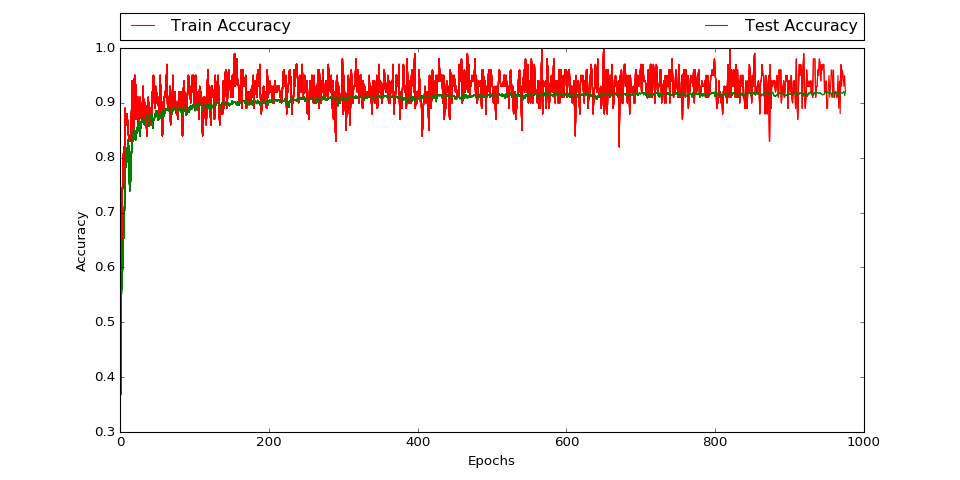

CPU times: user 27.5 s, sys: 8.17 s, total: 35.7 s
Wall time: 22.4 s


In [65]:
%%time
%matplotlib notebook
fig = plt.figure(figsize=(12,6), dpi=80)
ax = plt.subplot(111)
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
train_accuracies = []
test_accuracies = []
for i in range(1000):
    batch_xs, batch_ys = data_sets.train.next_batch(100)
    sess.run(train_step, feed_dict={x:batch_xs, t:batch_ys})
    train_accuracy_value = sess.run(accuracy, feed_dict={x:batch_xs, t: batch_ys})
    test_accuracy_value = sess.run(accuracy, feed_dict={x:data_sets.test.images, t: data_sets.test.labels})
    train_accuracies.append(train_accuracy_value)
    test_accuracies.append(test_accuracy_value)
    # those graph updates really decrease the speed of execution
    if i%25 ==0:
        train_line, = ax.plot(range(i+1), train_accuracies, 'r-', label='Train Accuracy')
        test_line, = ax.plot(range(i+1), test_accuracies, 'g-', label='Test Accuracy')
        ax.legend(handles=[train_line, test_line],
                      bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
        fig.canvas.draw()